# LIDA - Automatic Generation of Visualizations and Infographics using Large Language Models

- LIDA is a library for generating data visualizations and data-faithful infographics. 
- LIDA is grammar agnostic (will work with any programming language and visualization libraries e.g. matplotlib, seaborn, altair, d3 etc) and works with multiple large language model providers (Azure Open AI, OpenAI, PaLM, Cohere, Huggingface). 

References:
- https://arxiv.org/abs/2303.02927
- https://microsoft.github.io/lida/

<img src="https://microsoft.github.io/lida/files/lidamodules.jpg">

In [1]:
# %pip install lida
# %pip install lida[infographics] # for infographics support

# If you intend to use lida with local huggingface models, you will need to install the 'transformers' library.
# %pip install lida[transformers]

In [2]:
import datetime
import logging
import openai
import os
import pandas as pd
import seaborn as sns
import sys
import torch
import warnings

from dotenv import load_dotenv
from lida import Manager, TextGenerationConfig, llm
from lida.utils import plot_raster
from llmx.generators.text.openai_textgen import OpenAITextGenerator
from llmx.generators.text.textgen import sanitize_provider

In [3]:
# Removing some warning messages
logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

In [4]:
print(f"Today is {datetime.datetime.today().strftime('%d-%b-%Y %H:%M:%S')}")

Today is 23-Oct-2023 08:38:01


In [5]:
sys.version

'3.10.10 (main, Mar 21 2023, 18:45:11) [GCC 11.2.0]'

## 0. Settings

In [6]:
load_dotenv("azure.env")

# Azure Open AI
openai.api_type: str = "azure"
openai.api_key = os.getenv("OPENAI_API_KEY")
openai.api_base = os.getenv("OPENAI_API_BASE")
openai.api_version = os.getenv("OPENAI_API_VERSION")

print("Open AI version:", openai.__version__)

Open AI version: 0.28.1


In [7]:
provider = sanitize_provider("azureopenai")
models = {}

text_gen = OpenAITextGenerator(
    api_key=os.environ["OPENAI_API_KEY"],
    api_base=os.environ["OPENAI_API_BASE"],
    provider=provider,
    models=models,
)

lida = Manager(text_gen=text_gen)

## 1. Data

In [8]:
if not os.path.exists("Titanic.csv"):
    print("Downloading csv data file...")
    !wget https://raw.githubusercontent.com/retkowsky/DataSets-AutoML_AzureMLservice/master/Titanic.csv
    print("Done\n")
    !ls Titanic.csv -lh

--2023-10-23 08:38:06--  https://raw.githubusercontent.com/retkowsky/DataSets-AutoML_AzureMLservice/master/Titanic.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60302 (59K) [text/plain]
Saving to: ‘Titanic.csv’

Titanic.csv         100%[===================>]  58.89K  --.-KB/s    in 0.02s   

2023-10-23 08:38:06 (3.58 MB/s) - ‘Titanic.csv’ saved [60302/60302]

Done

-rwxrwxrwx 1 root root 59K Oct 23 08:38 Titanic.csv


In [9]:
df = pd.read_csv("Titanic.csv")
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [10]:
df.shape

(891, 12)

In [11]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [12]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

## 2. LIDA settings

In [13]:
model = "gpt-35-turbo"  # You Azure Open AI model

In [14]:
lida = Manager(text_gen=llm("openai", api_key=None))
textgen_config = TextGenerationConfig(n=1, temperature=0.7, model=model, use_cache=True)

In [15]:
textgen_config

TextGenerationConfig(n=1, temperature=0.7, max_tokens=None, top_p=1.0, top_k=50, frequency_penalty=0.0, presence_penalty=0.0, provider=None, model='gpt-35-turbo', stop=None, use_cache=True)

In [16]:
summary = lida.summarize(
    df,
    summary_method="default",
    textgen_config=textgen_config,
)

In [17]:
summary["field_names"]

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

In [18]:
summary

{'name': '',
 'file_name': '',
 'dataset_description': '',
 'fields': [{'column': 'PassengerId',
   'properties': {'dtype': 'number',
    'std': 257,
    'min': 1,
    'max': 891,
    'samples': [710, 440, 841],
    'num_unique_values': 891,
    'semantic_type': '',
    'description': ''}},
  {'column': 'Survived',
   'properties': {'dtype': 'number',
    'std': 0,
    'min': 0,
    'max': 1,
    'samples': [1, 0],
    'num_unique_values': 2,
    'semantic_type': '',
    'description': ''}},
  {'column': 'Pclass',
   'properties': {'dtype': 'number',
    'std': 0,
    'min': 1,
    'max': 3,
    'samples': [3, 1],
    'num_unique_values': 3,
    'semantic_type': '',
    'description': ''}},
  {'column': 'Name',
   'properties': {'dtype': 'string',
    'samples': ['Moubarek, Master. Halim Gonios ("William George")',
     'Kvillner, Mr. Johan Henrik Johannesson'],
    'num_unique_values': 891,
    'semantic_type': '',
    'description': ''}},
  {'column': 'Sex',
   'properties': {'dtype'

## 3. Goals

In [19]:
%%javascript Python
OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

In [20]:
goals = lida.goals(summary, n=10, textgen_config=textgen_config)

for goal in goals:
    display(goal)


### Goal 0
---
**Question:** What is the distribution of passenger ages?

**Visualization:** `histogram of Age`

**Rationale:** This tells us the range and frequency of passenger ages in the dataset.



### Goal 1
---
**Question:** How many passengers survived the Titanic?

**Visualization:** `bar chart of Survived`

**Rationale:** This shows the number of passengers who survived versus those who did not.



### Goal 2
---
**Question:** What was the average age of passengers in each passenger class?

**Visualization:** `grouped bar chart of Pclass and Age`

**Rationale:** This helps us understand if age varied by passenger class.



### Goal 3
---
**Question:** What was the fare distribution for each passenger class?

**Visualization:** `box plot of Pclass and Fare`

**Rationale:** This shows the distribution of fares for each passenger class, including any outliers.



### Goal 4
---
**Question:** How did the number of passengers vary by embarkation port?

**Visualization:** `bar chart of Embarked`

**Rationale:** This shows the number of passengers who embarked at each port.



### Goal 5
---
**Question:** What was the survival rate by passenger class?

**Visualization:** `stacked bar chart of Pclass and Survived`

**Rationale:** This shows the proportion of passengers who survived in each passenger class.



### Goal 6
---
**Question:** What was the survival rate by gender?

**Visualization:** `stacked bar chart of Sex and Survived`

**Rationale:** This shows the proportion of passengers who survived by gender.



### Goal 7
---
**Question:** What was the distribution of passenger fares?

**Visualization:** `histogram of Fare`

**Rationale:** This tells us the range and frequency of passenger fares in the dataset.



### Goal 8
---
**Question:** What was the average number of siblings/spouses aboard for each passenger class?

**Visualization:** `grouped bar chart of Pclass and SibSp`

**Rationale:** This helps us understand if the number of siblings/spouses aboard varied by passenger class.



### Goal 9
---
**Question:** What was the survival rate of passengers with and without parents/children aboard?

**Visualization:** `stacked bar chart of Parch and Survived`

**Rationale:** This shows the proportion of passengers who survived based on whether they had parents/children aboard.


In [21]:
persona = "I want some analysis for people who embarked in Southampton"

personal_goals = lida.goals(
    summary, n=2, persona=persona, textgen_config=textgen_config
)

for goal in personal_goals:
    display(goal)


### Goal 0
---
**Question:** What is the survival rate for passengers who embarked in Southampton compared to those who embarked in Cherbourg and Queenstown?

**Visualization:** `Bar chart of survival rate by embarkation port`

**Rationale:** This will help us understand if there is a correlation between the port of embarkation and the likelihood of survival, which could be useful for future safety measures. The 'Embarked' field will be used to group the data and the 'Survived' field will be used to calculate the survival rate.



### Goal 1
---
**Question:** What is the age distribution of female passengers who embarked in Southampton?

**Visualization:** `Histogram of age for female passengers who embarked in Southampton`

**Rationale:** This will help us understand the age demographics of the female passengers who embarked in Southampton, which could be useful for targeted marketing campaigns or customer segmentation. The 'Embarked' and 'Sex' fields will be used to filter the data and the 'Age' field will be used to create the histogram.


In [22]:
persona = "I want some survival analysis for people in third class"

personal_goals = lida.goals(
    summary, n=2, persona=persona, textgen_config=textgen_config
)

for goal in personal_goals:
    display(goal)


### Goal 0
---
**Question:** What is the survival rate of people in third class compared to other classes?

**Visualization:** `grouped bar chart of Pclass and Survived`

**Rationale:** This visualization will help us understand the survival rate of people in third class compared to other classes. By comparing the number of survivors and non-survivors in each class, we can identify if there is a significant difference in the survival rate among the classes. This will be useful for our persona who is interested in survival analysis for people in third class.



### Goal 1
---
**Question:** What is the age distribution of survivors in third class?

**Visualization:** `histogram of Age for Survived passengers in Pclass 3`

**Rationale:** This visualization will help us understand the age distribution of survivors in third class. By plotting the age distribution, we can identify if there is an age group that has a higher survival rate. This will be useful for our persona who is interested in complex and insightful goals about the data for people in third class.


## 4. EDA

In [23]:
sns.set(rc={"figure.figsize": (15, 10)})

In [24]:
i = 0
library = "seaborn"  # Or plotly, ggplot ...

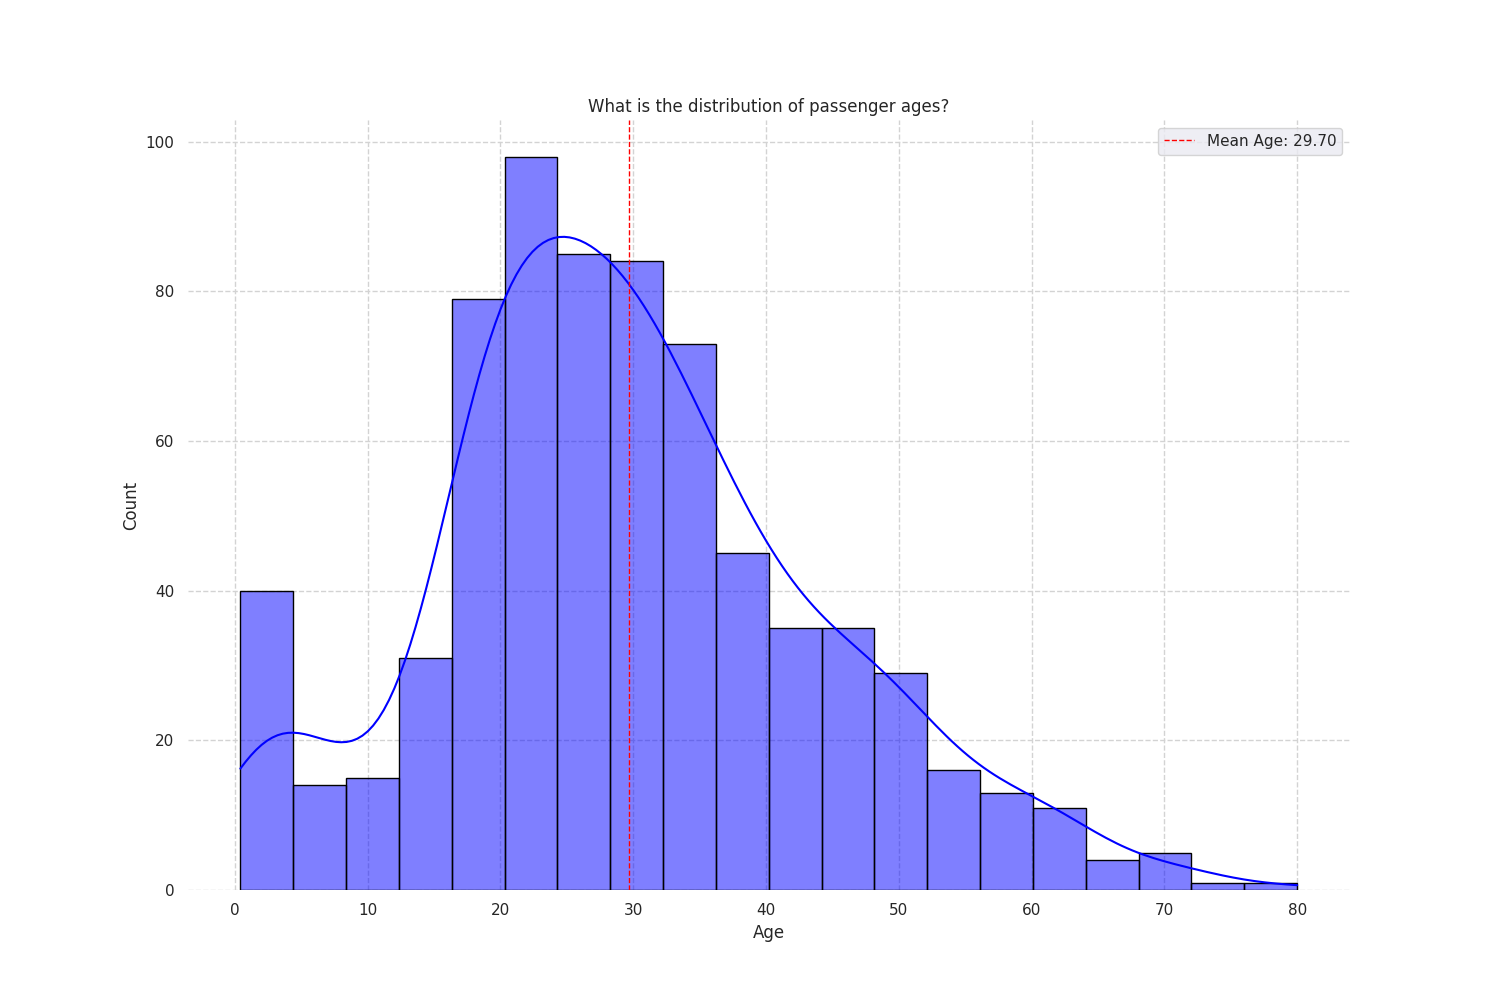

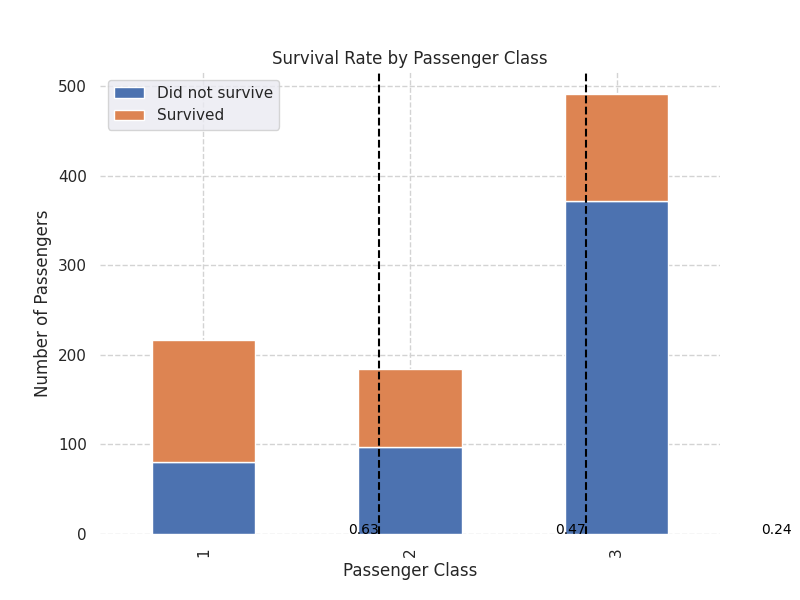

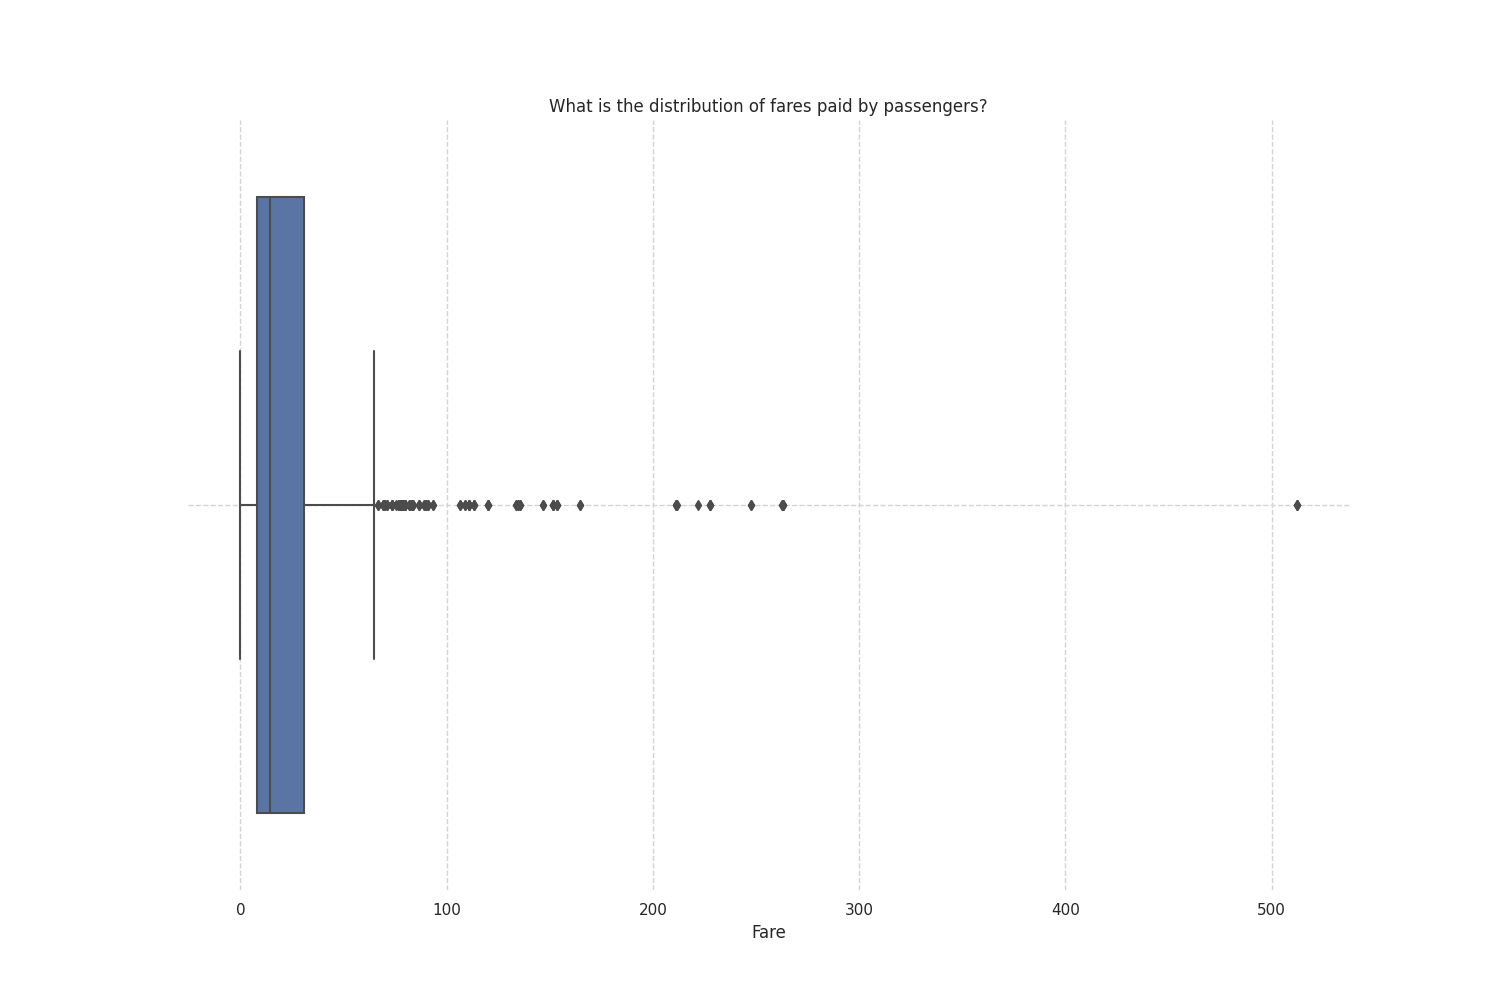

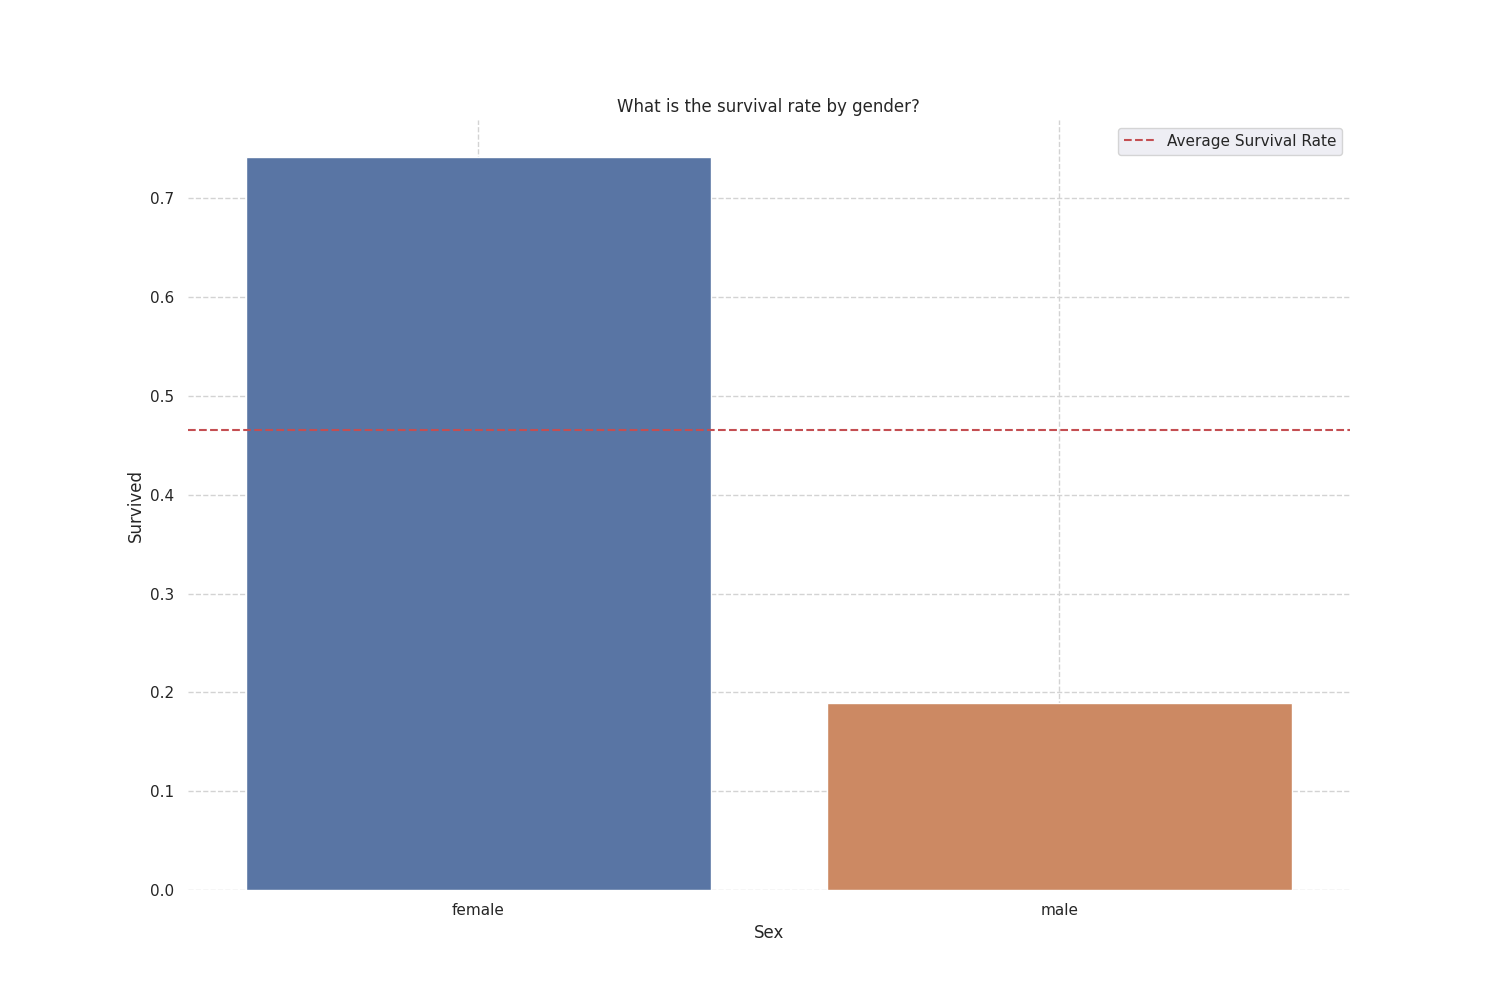

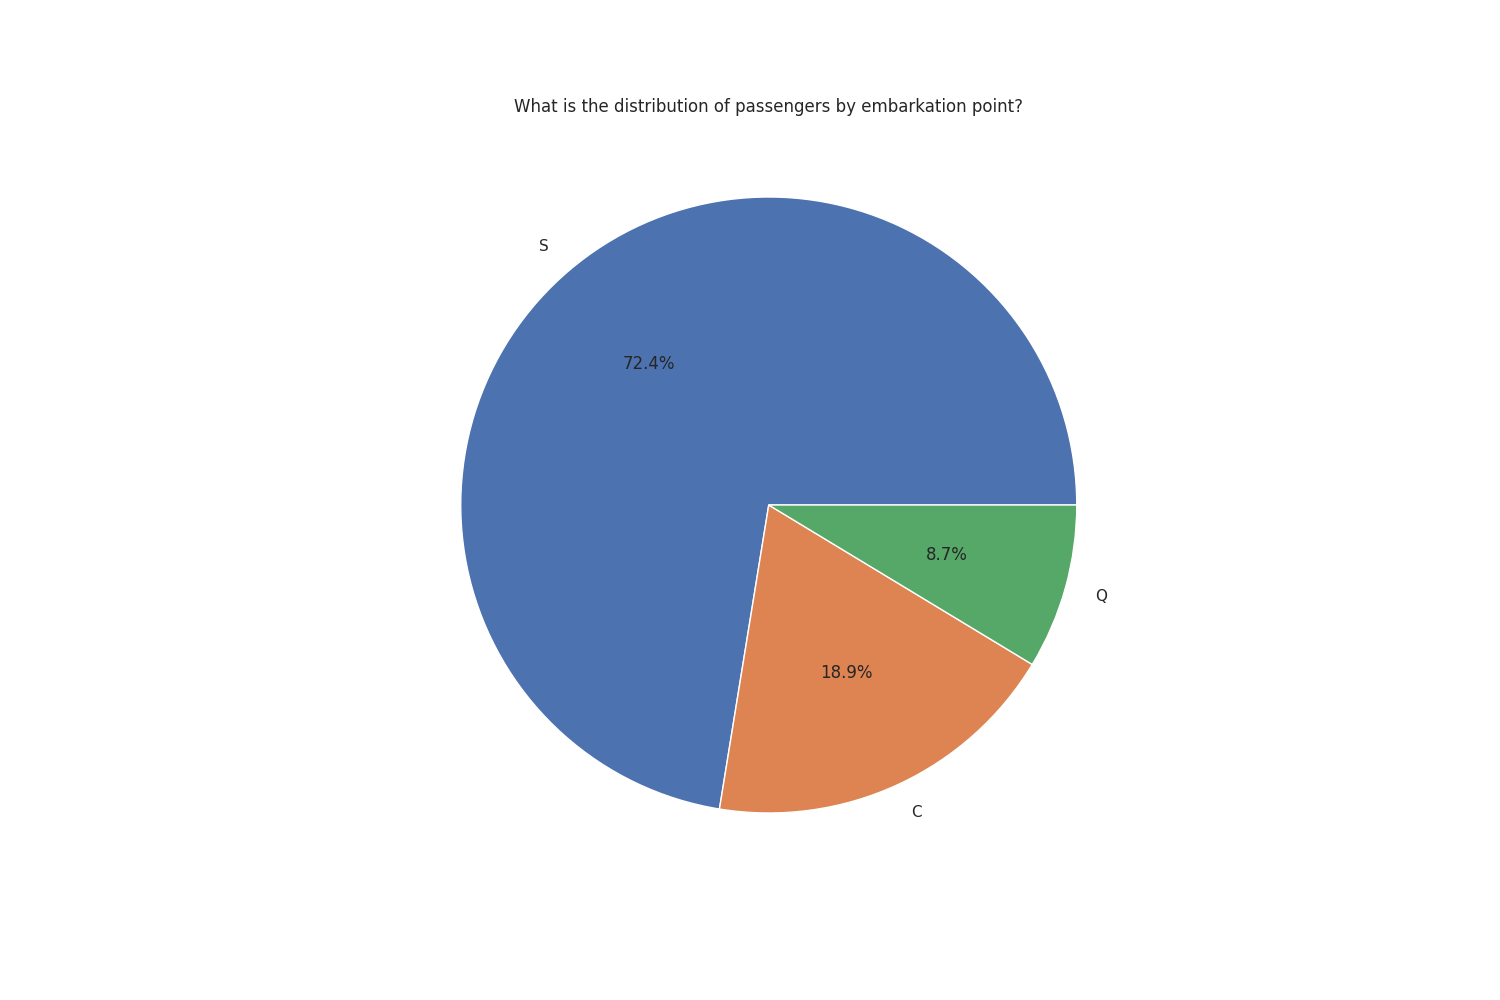

In [25]:
nb = 5

summary = lida.summarize("Titanic.csv")
goals = lida.goals(summary, n=nb)  # exploratory data analysis

for i in range(nb):
    charts = lida.visualize(summary=summary, goal=goals[i])
    for chart in charts:
        display(chart)

## 5. Charts

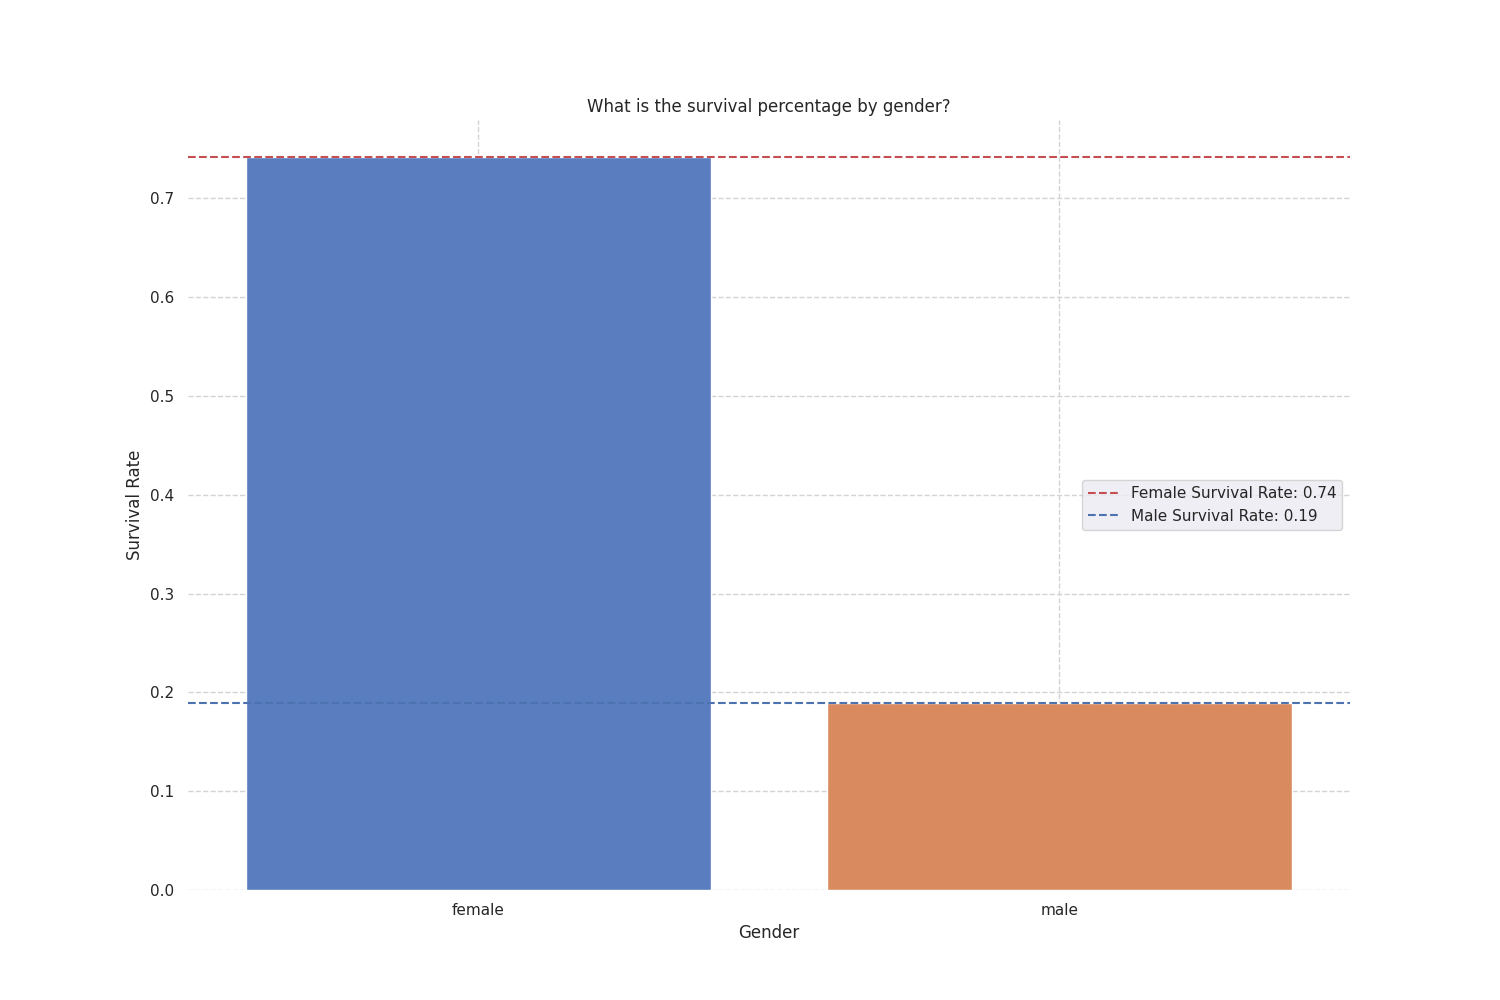

In [26]:
user_query = "What is the survival percentage by gender?"

textgen_config = TextGenerationConfig(n=1, temperature=0.2, use_cache=True)
charts = lida.visualize(summary=summary, goal=user_query, textgen_config=textgen_config)
charts[0]

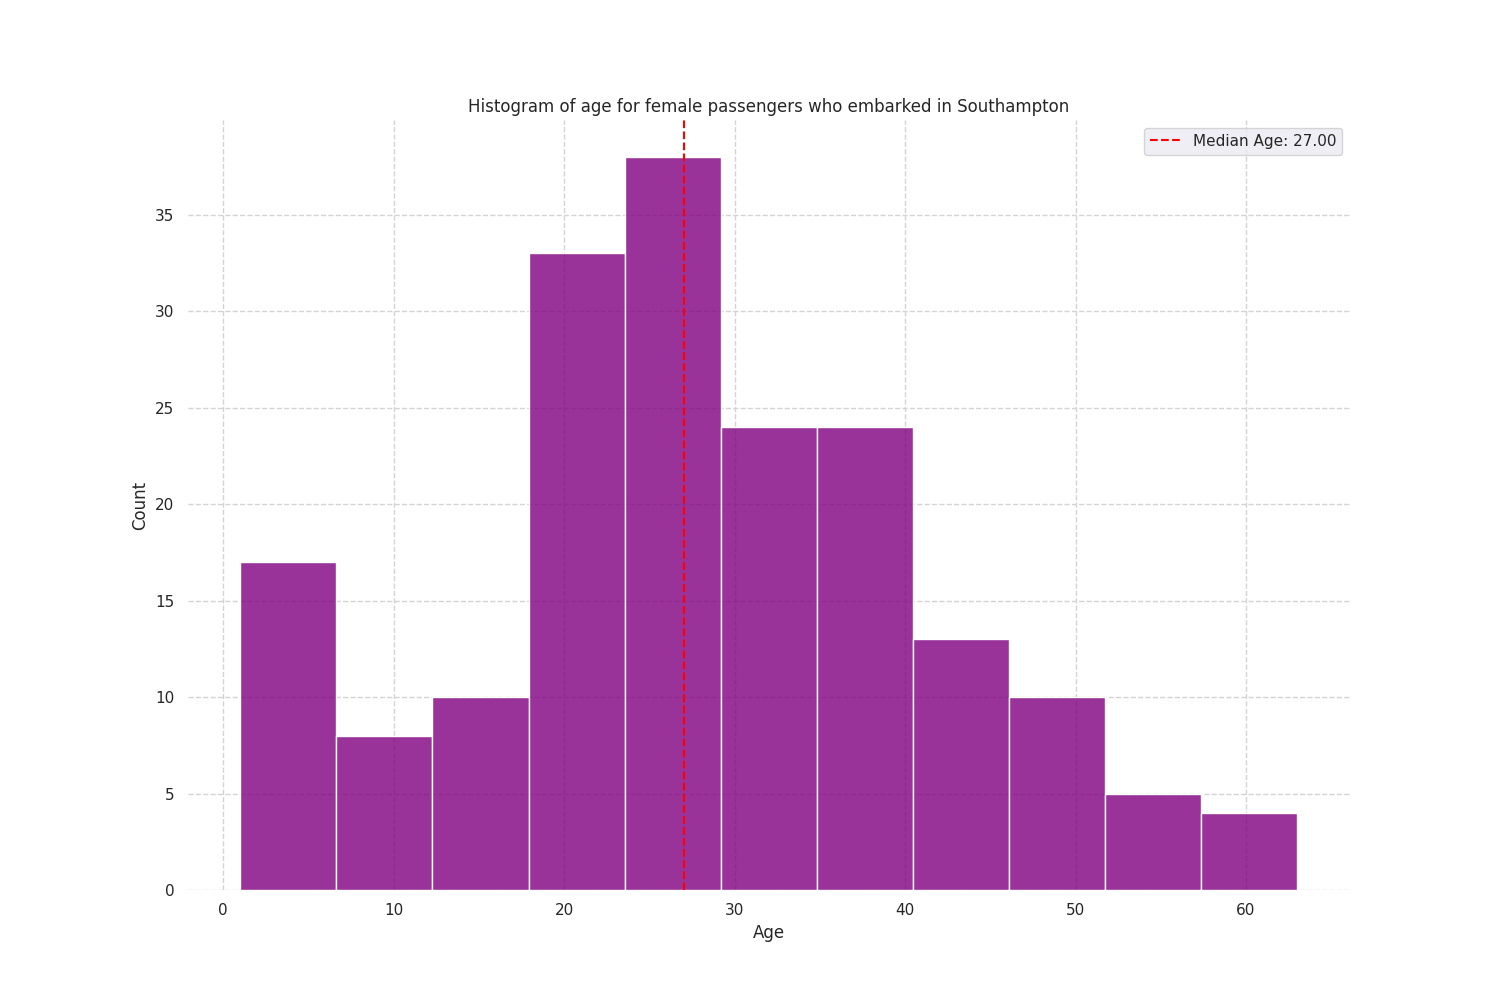

In [27]:
user_query = "Histogram of age for female passengers who embarked in Southampton"

textgen_config = TextGenerationConfig(n=1, temperature=0.2, use_cache=True)
charts = lida.visualize(summary=summary, goal=user_query, textgen_config=textgen_config)
charts[0]

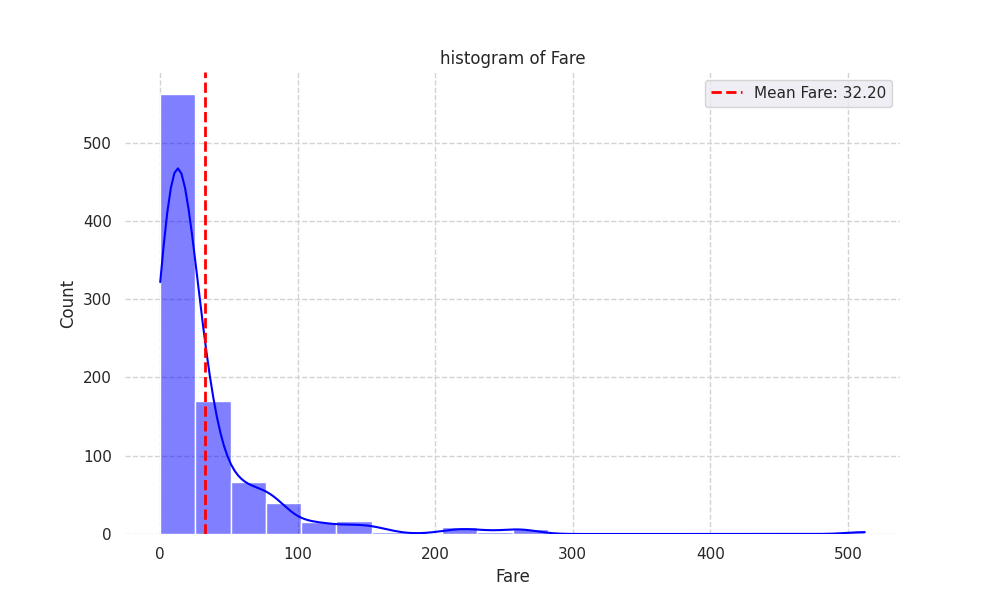

In [28]:
user_query = "histogram of Fare"

textgen_config = TextGenerationConfig(n=1, temperature=0.2, use_cache=True)
charts = lida.visualize(summary=summary, goal=user_query, textgen_config=textgen_config)
charts[0]

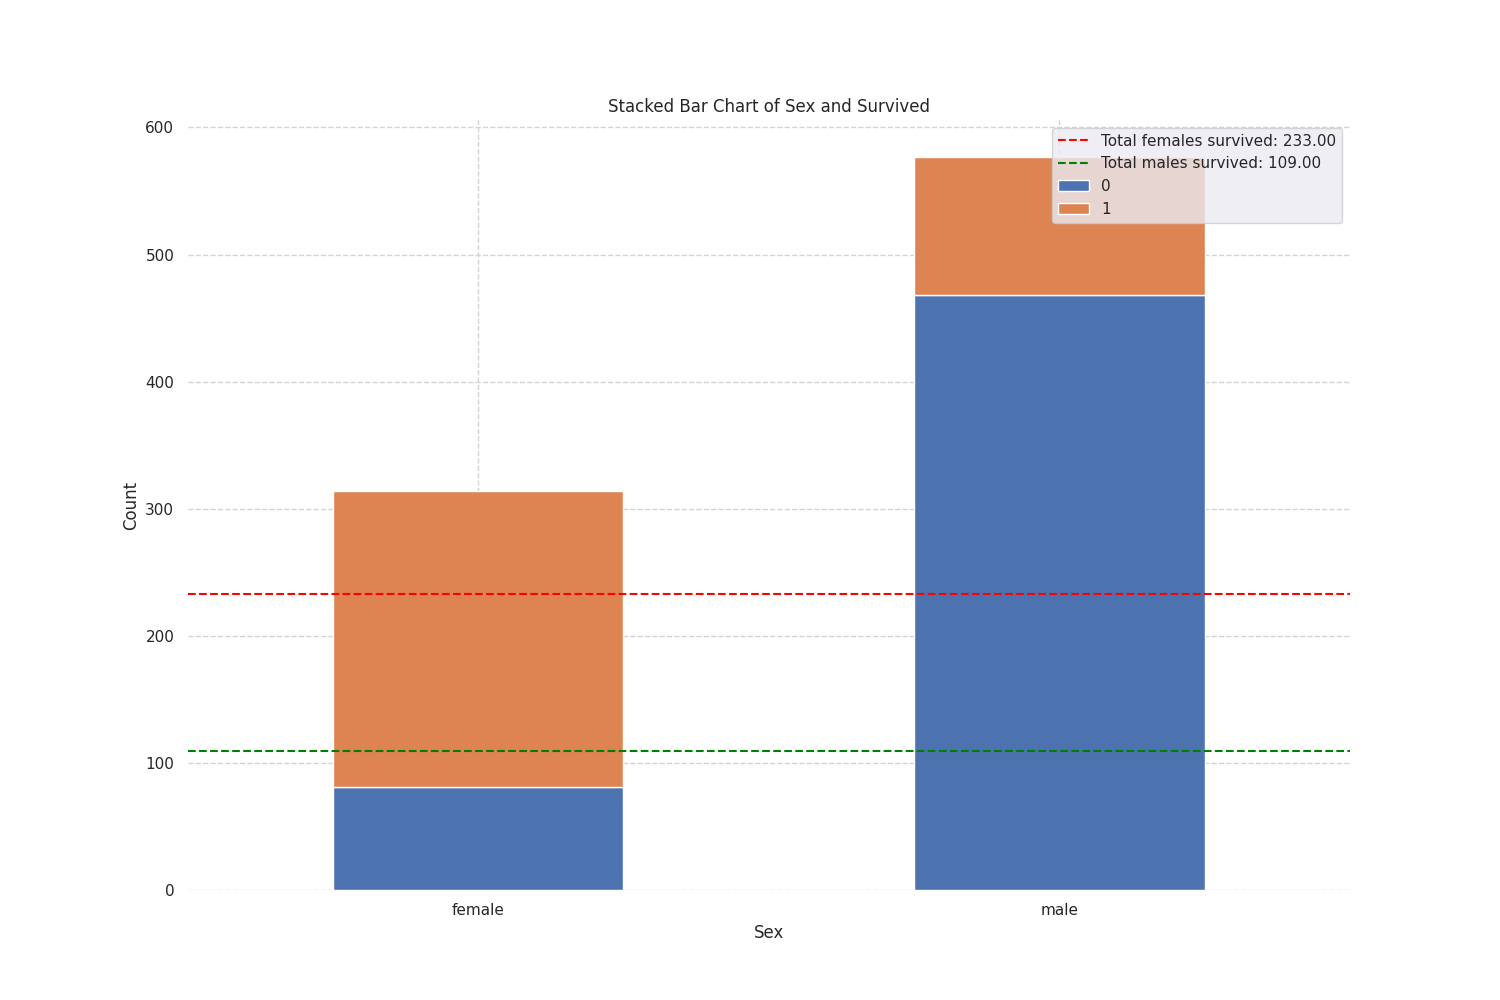

In [29]:
user_query = "stacked bar chart of Sex and Survived"

textgen_config = TextGenerationConfig(n=1, temperature=0.2, use_cache=True)
charts = lida.visualize(summary=summary, goal=user_query, textgen_config=textgen_config)
charts[0]

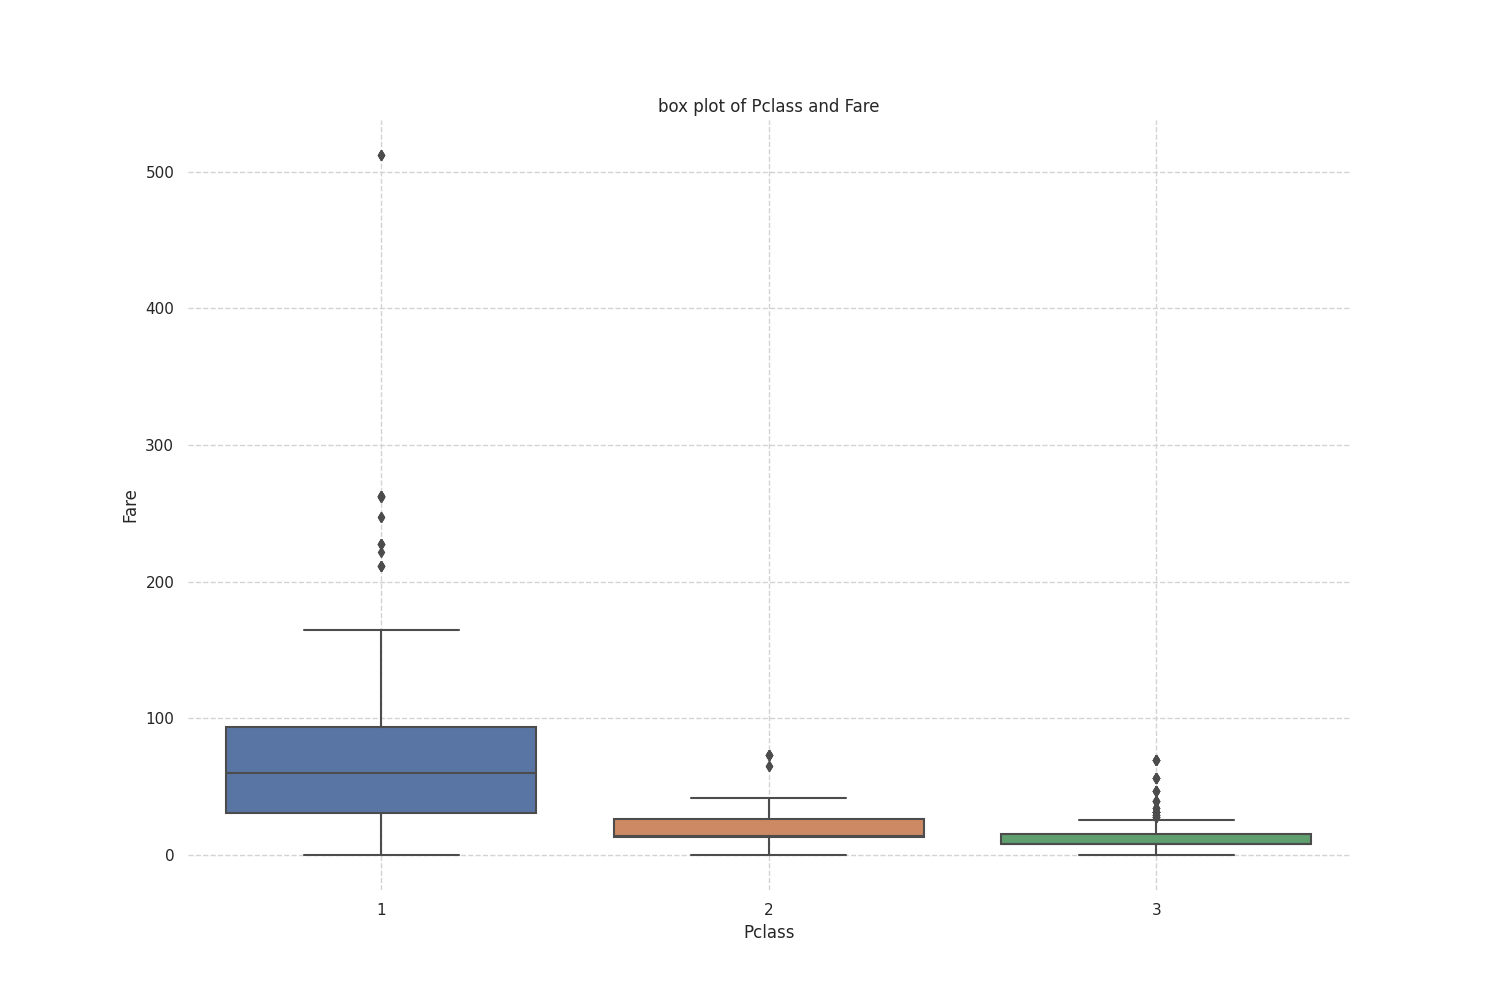

In [30]:
user_query = "box plot of Pclass and Fare"

textgen_config = TextGenerationConfig(n=1, temperature=0.2, use_cache=True)
charts = lida.visualize(summary=summary, goal=user_query, textgen_config=textgen_config)
charts[0]

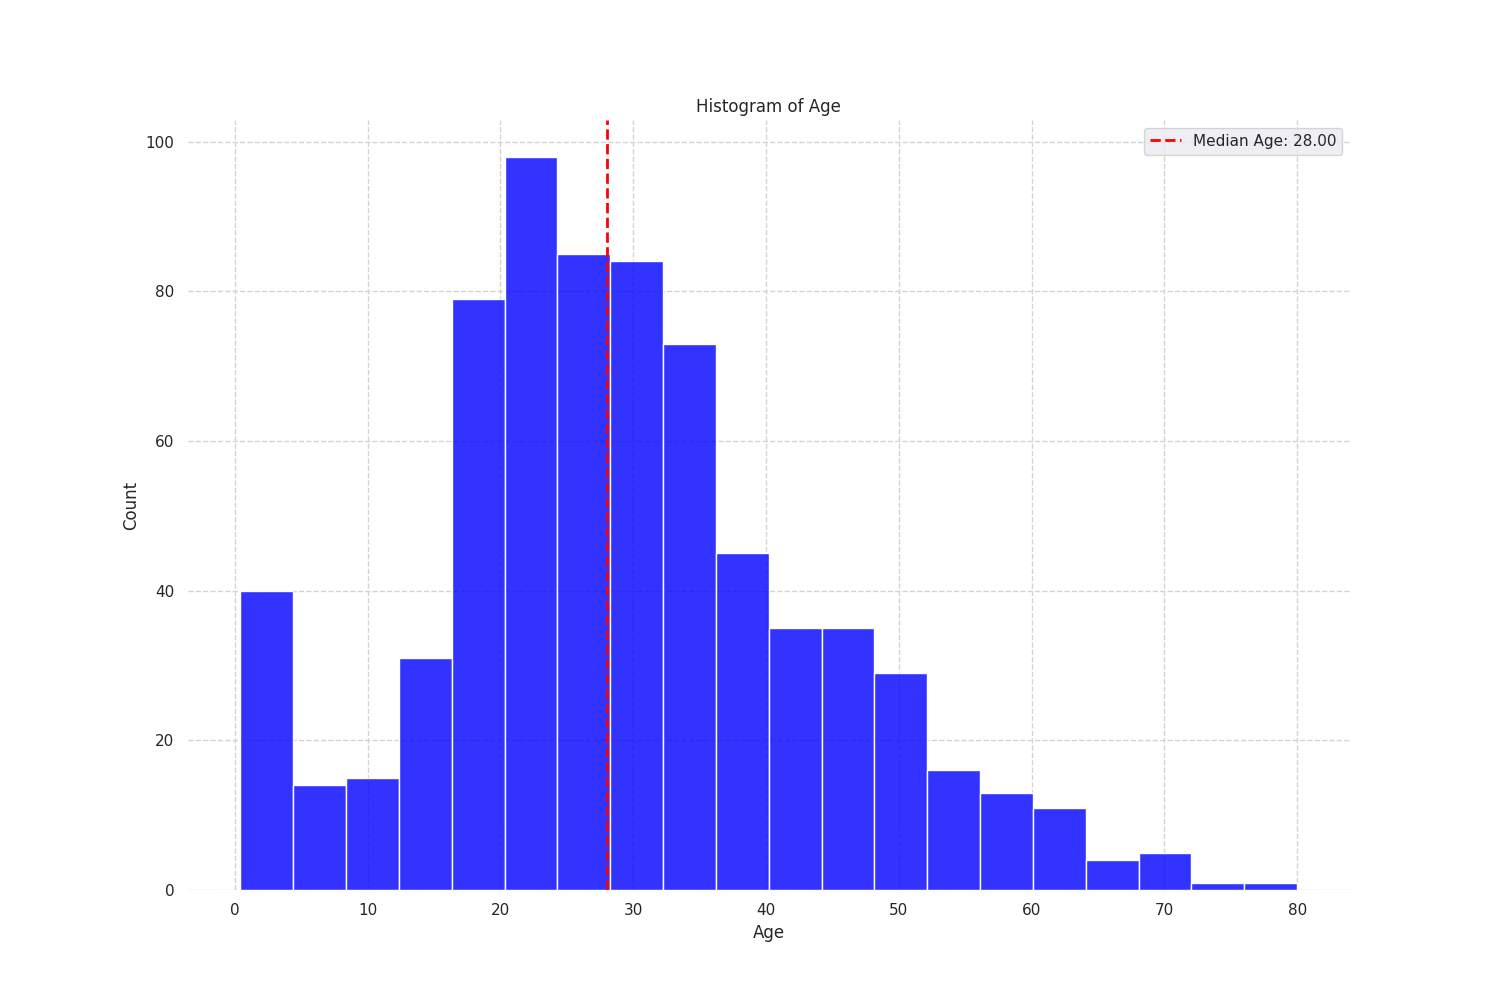

In [31]:
user_query = "histogram of Age"

textgen_config = TextGenerationConfig(n=1, temperature=0.2, use_cache=True)
charts = lida.visualize(summary=summary, goal=user_query, textgen_config=textgen_config)
charts[0]

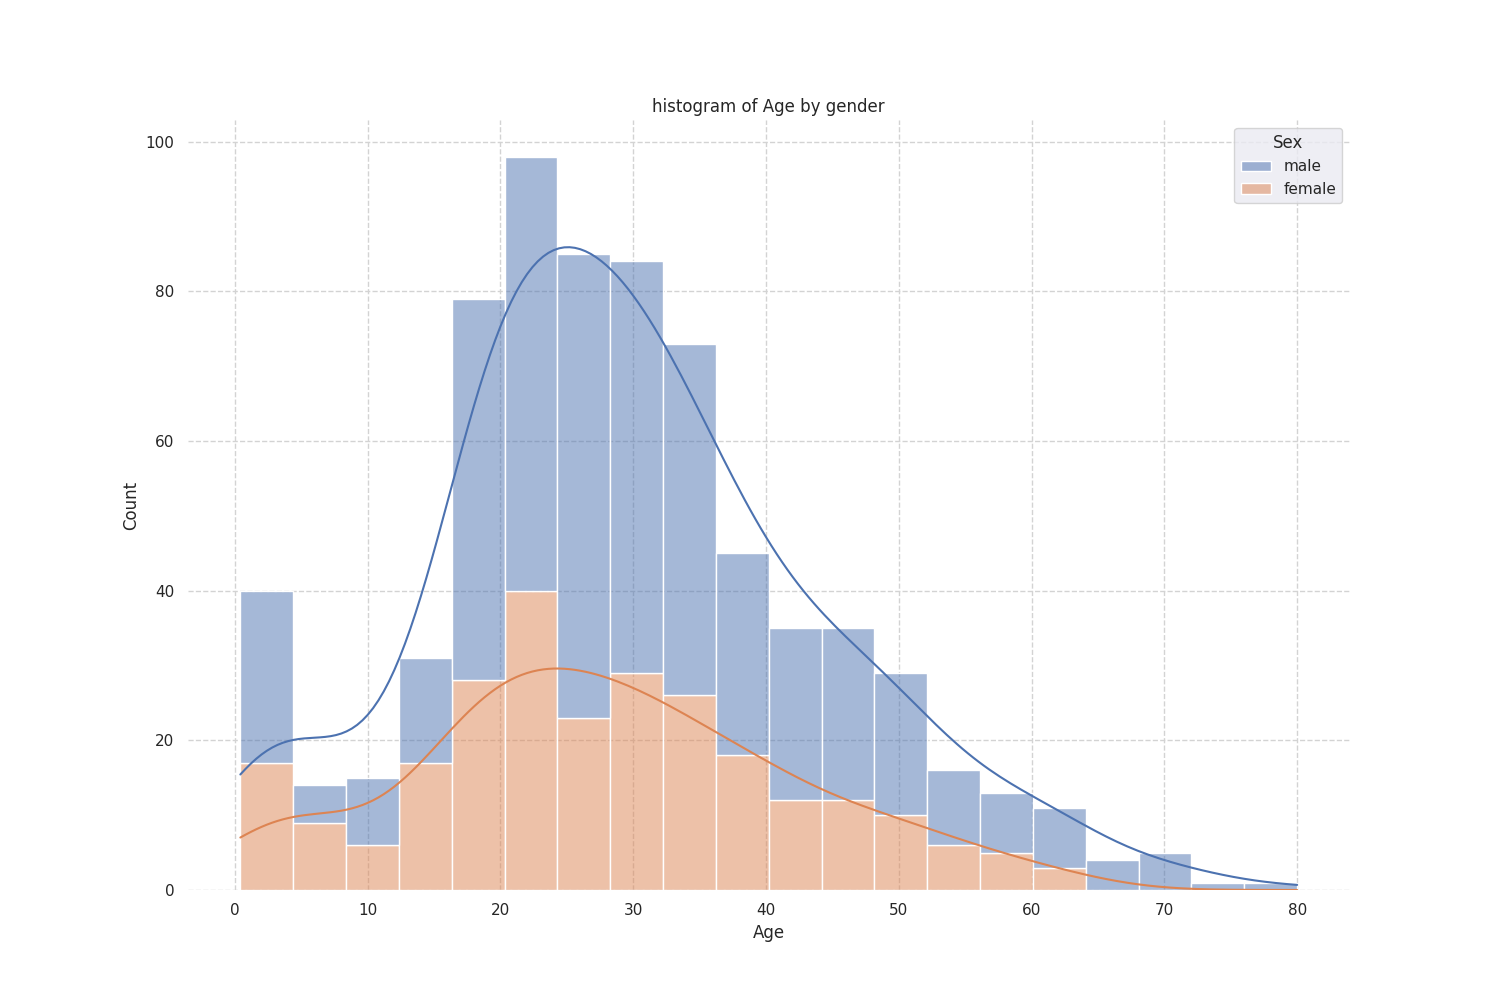

In [32]:
user_query = "histogram of Age by gender"

textgen_config = TextGenerationConfig(n=1, temperature=0.2, use_cache=True)
charts = lida.visualize(summary=summary, goal=user_query, textgen_config=textgen_config)
charts[0]

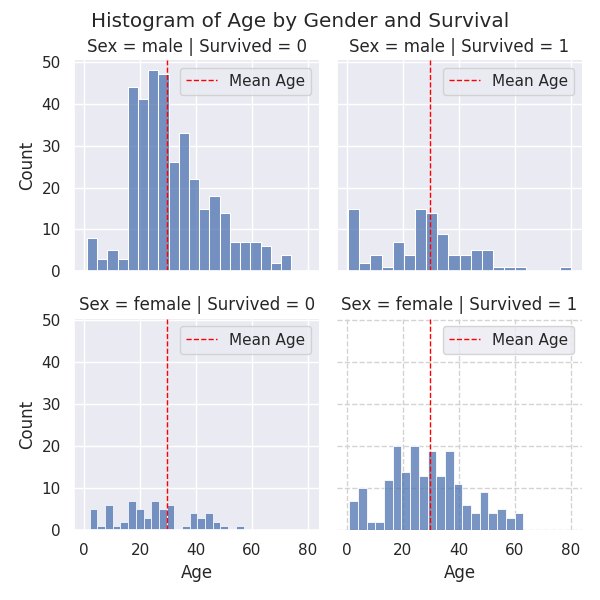

In [33]:
user_query = "histogram of Age by gender and survival"

textgen_config = TextGenerationConfig(n=1, temperature=0.2, use_cache=True)
charts = lida.visualize(summary=summary, goal=user_query, textgen_config=textgen_config)
charts[0]

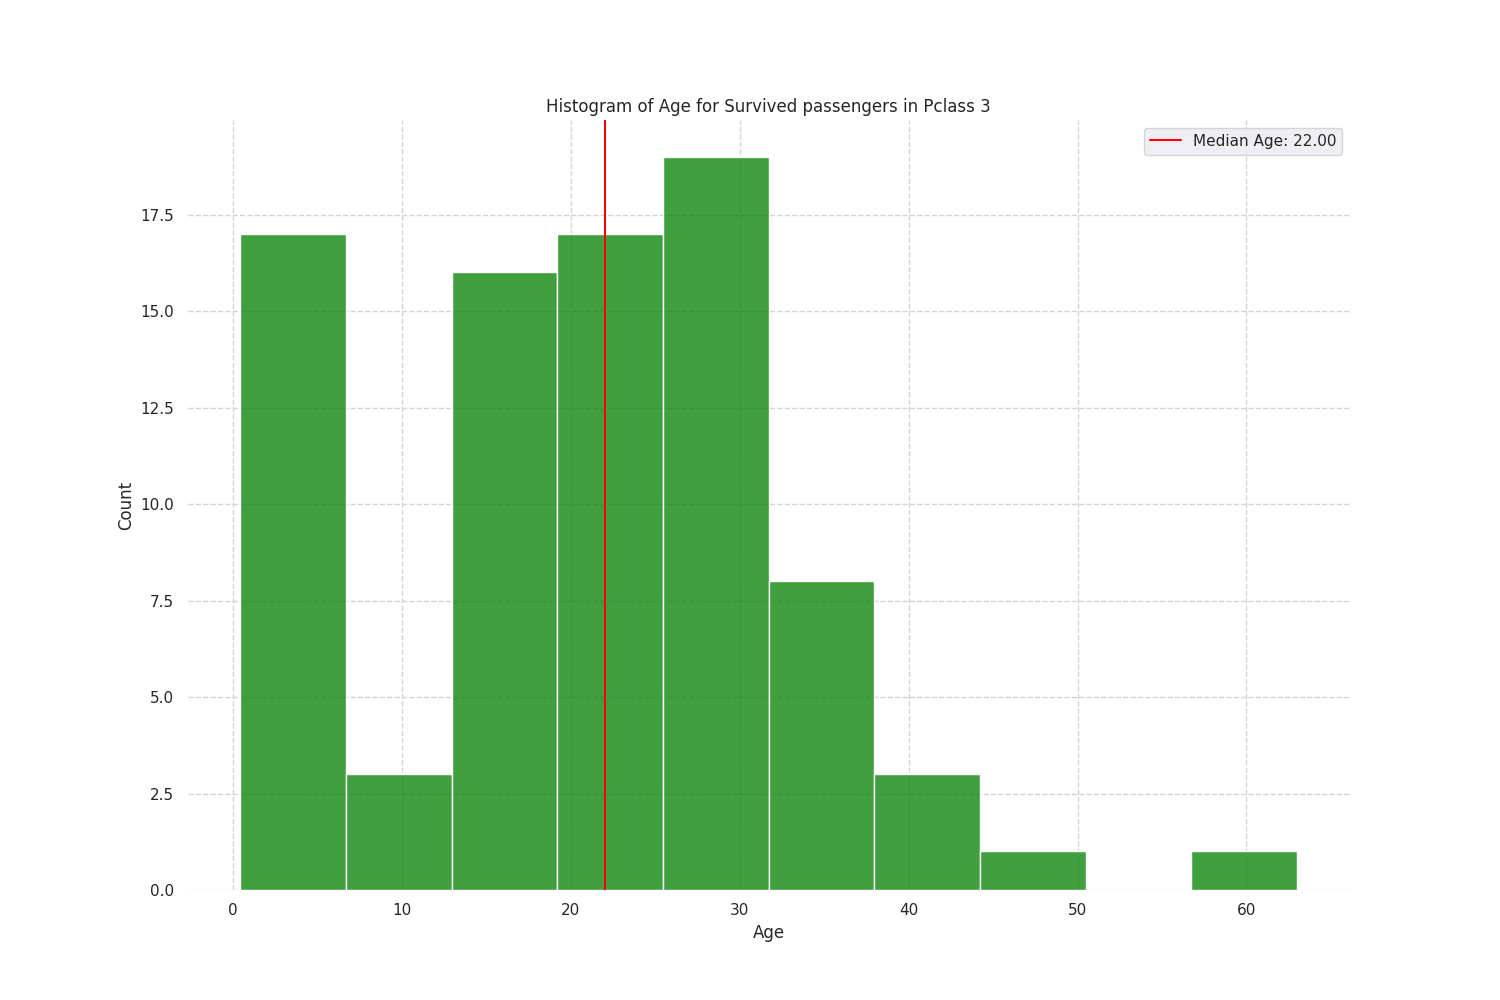

In [34]:
user_query = "histogram of Age for Survived passengers in Pclass 3"

textgen_config = TextGenerationConfig(n=1, temperature=0.2, use_cache=True)
charts = lida.visualize(summary=summary, goal=user_query, textgen_config=textgen_config)
charts[0]

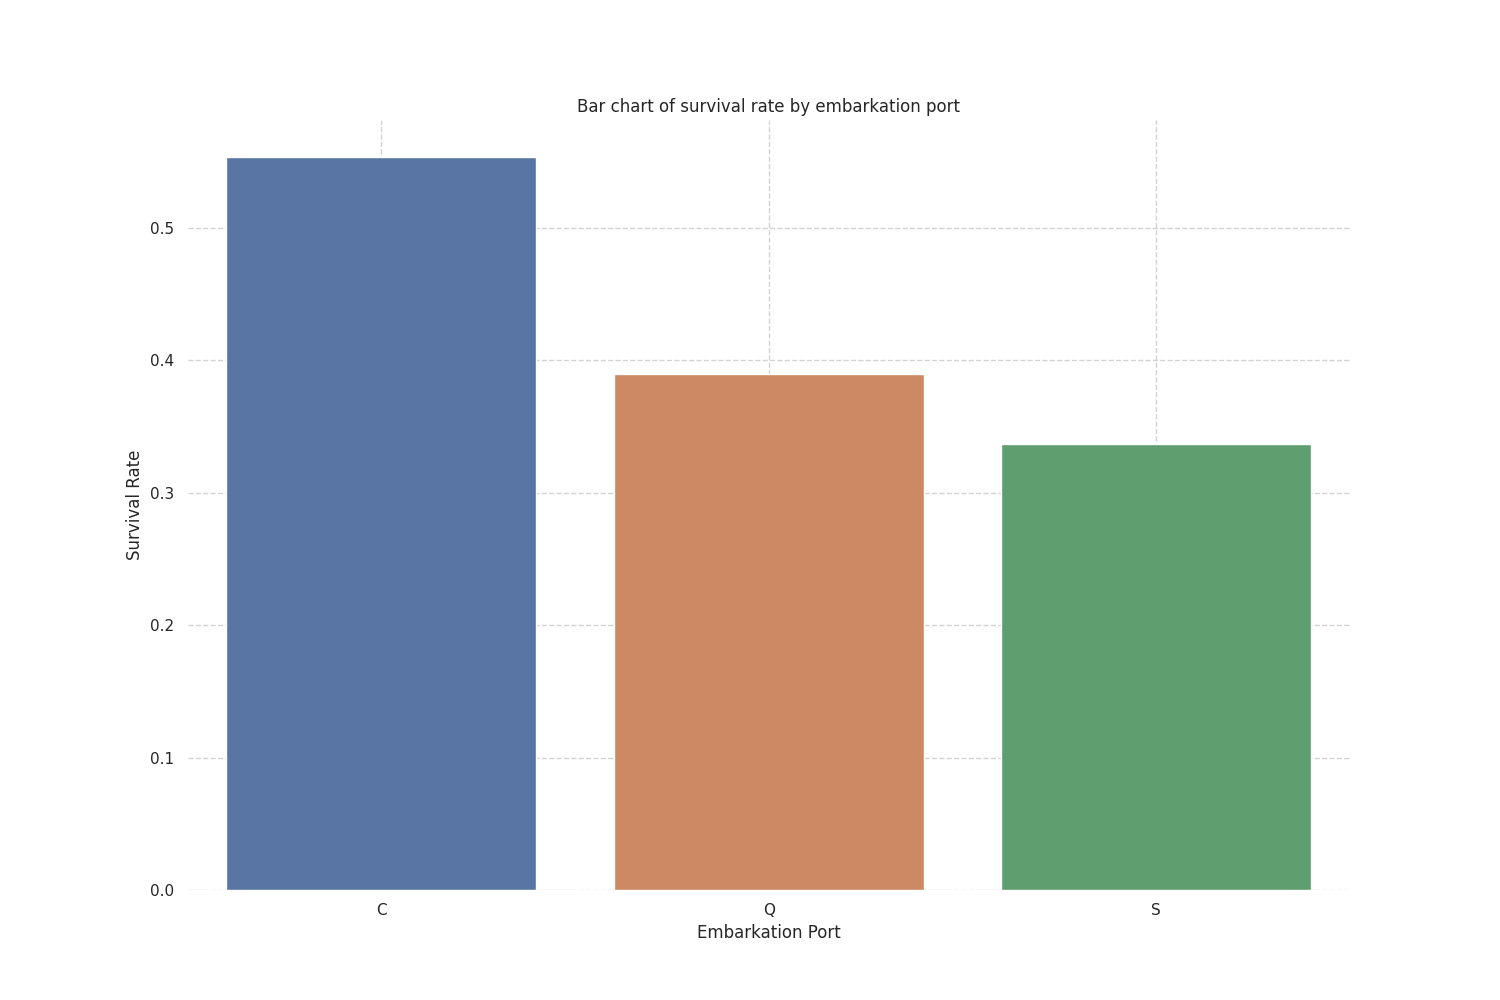

In [35]:
user_query = "Bar chart of survival rate by embarkation port"

textgen_config = TextGenerationConfig(n=1, temperature=0.2, use_cache=True)
charts = lida.visualize(summary=summary, goal=user_query, textgen_config=textgen_config)
charts[0]

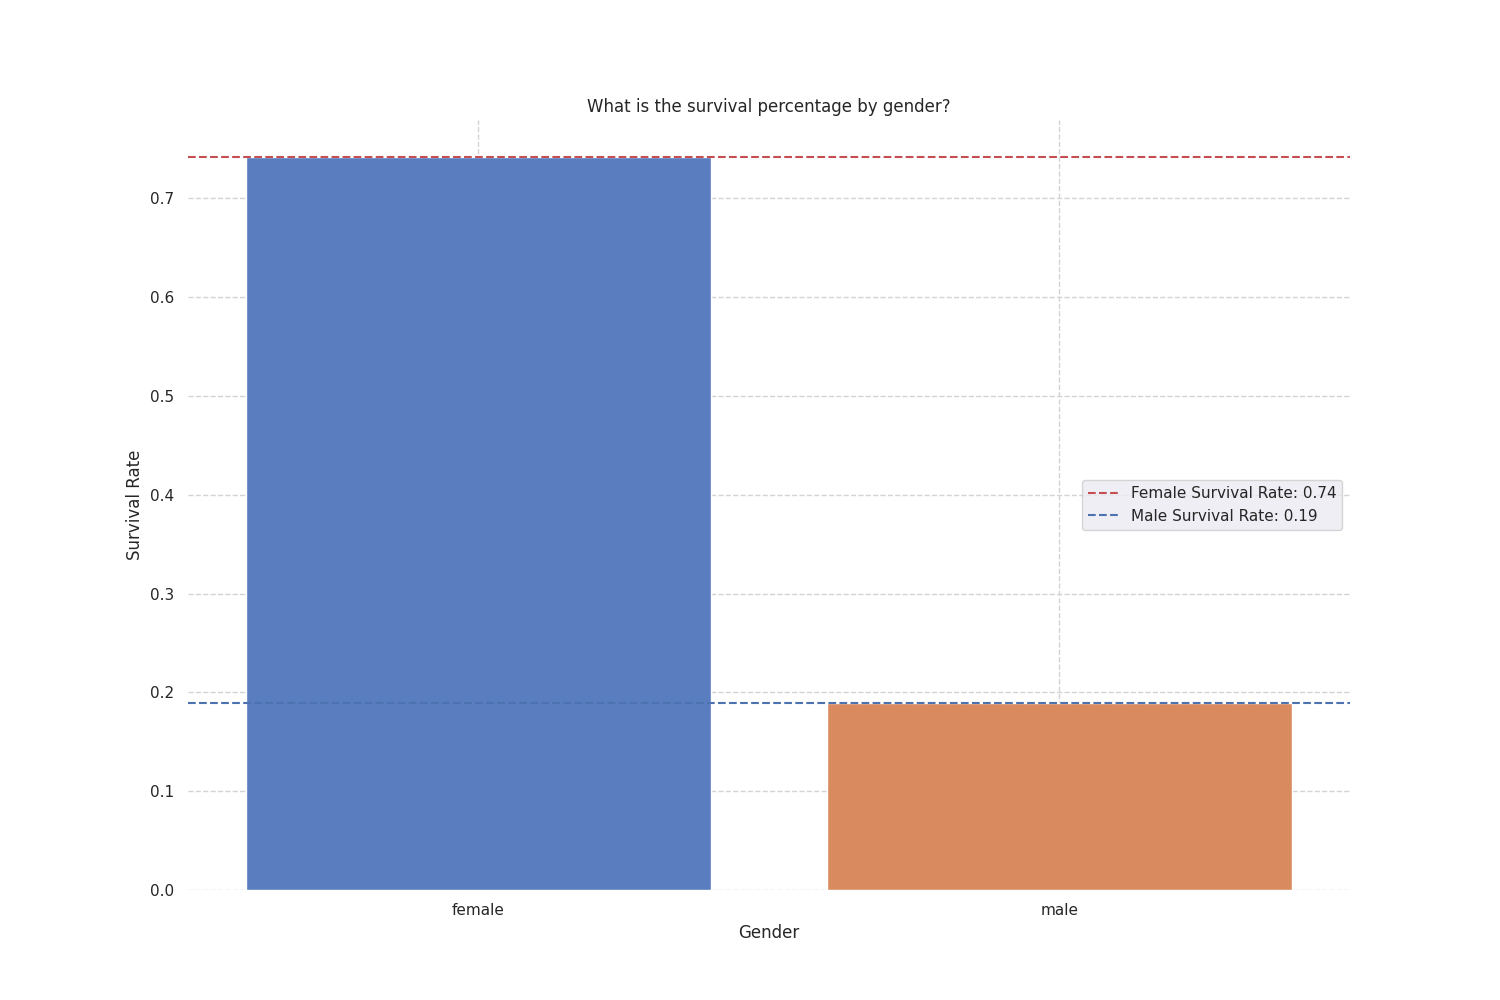

In [36]:
user_query = "What is the survival percentage by gender?"

textgen_config = TextGenerationConfig(n=1, temperature=0.2, use_cache=True)
charts = lida.visualize(summary=summary, goal=user_query, textgen_config=textgen_config)
charts[0]

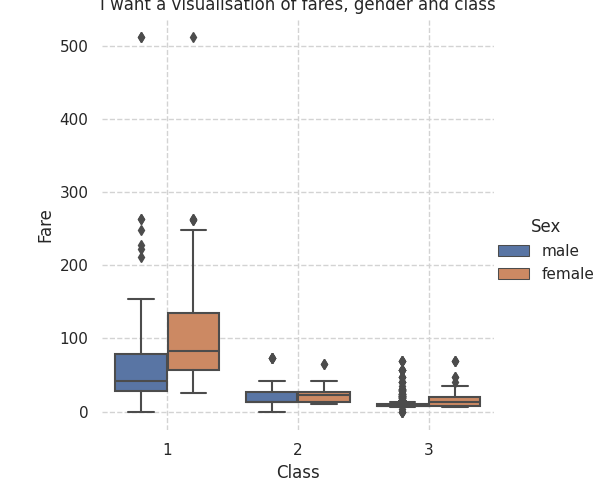

In [37]:
user_query = "I want a visualisation of fares, gender and class"

textgen_config = TextGenerationConfig(n=1, temperature=0.2, use_cache=True)
charts = lida.visualize(summary=summary, goal=user_query, textgen_config=textgen_config)
charts[0]

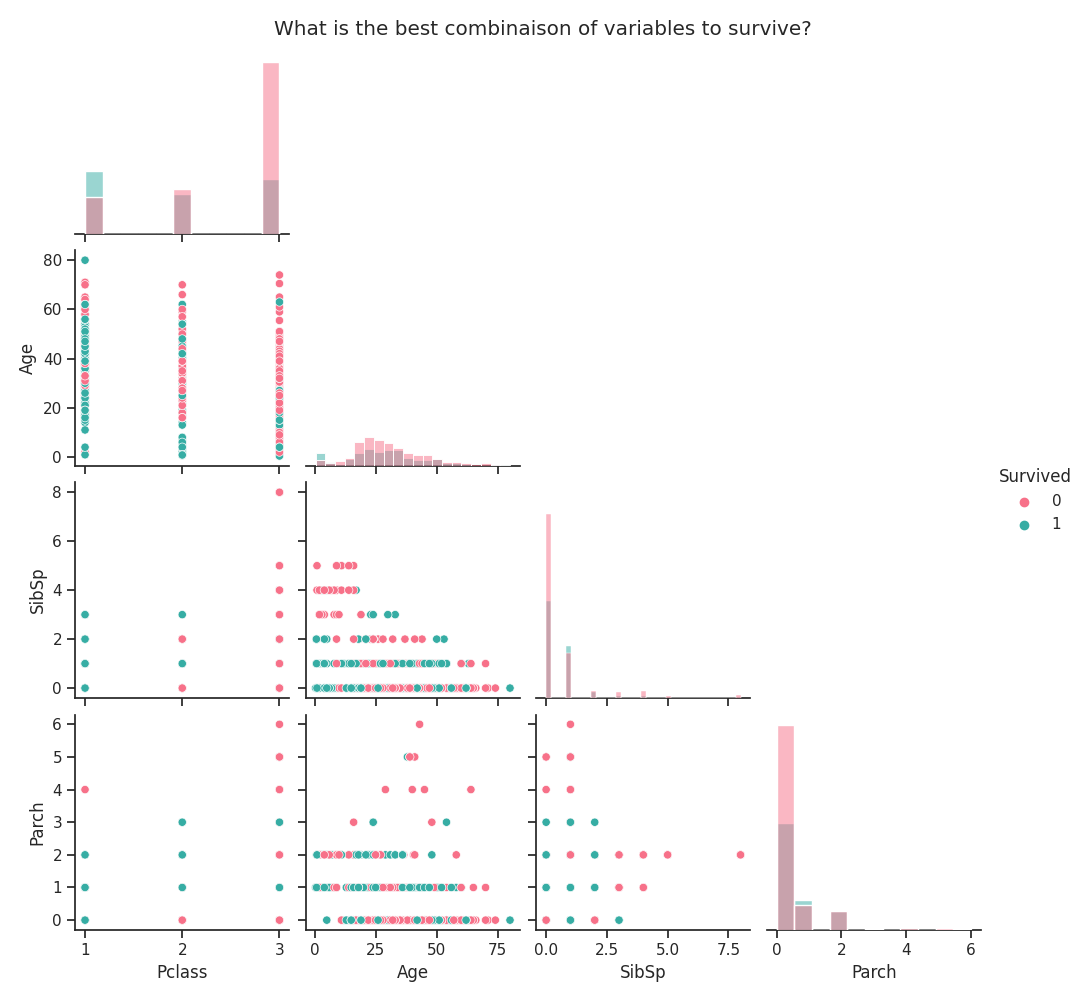

In [38]:
user_query = "What is the best combinaison of variables to survive?"

textgen_config = TextGenerationConfig(n=1, temperature=0.2, use_cache=True)
charts = lida.visualize(summary=summary, goal=user_query, textgen_config=textgen_config)
charts[0]

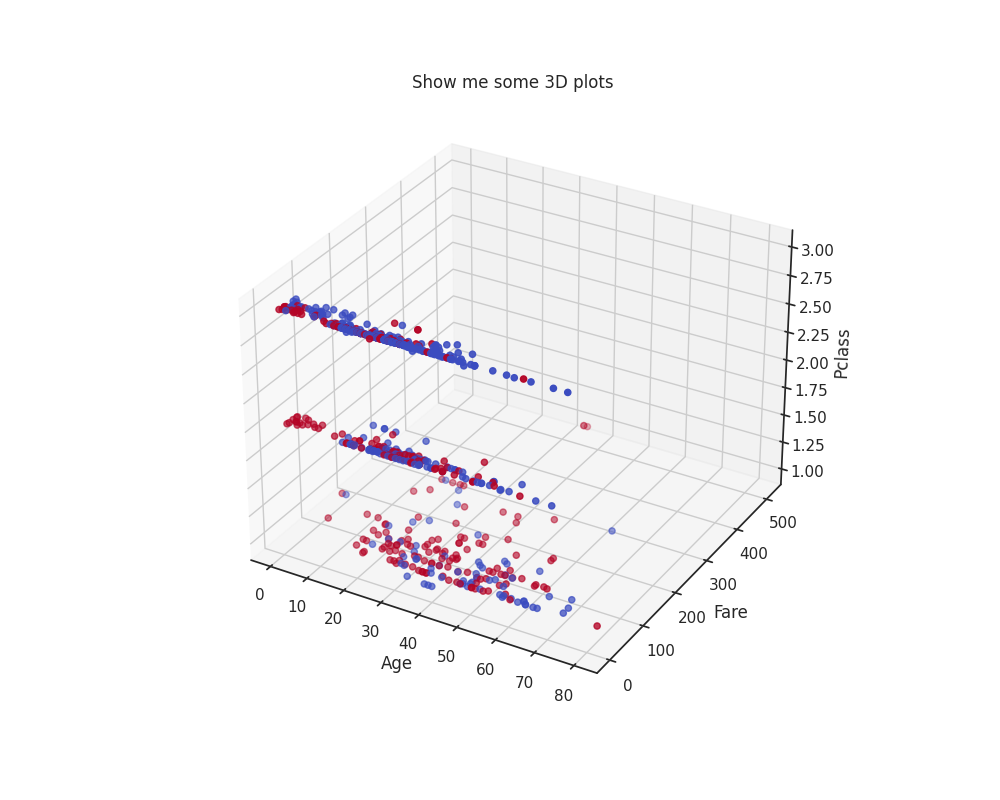

In [39]:
user_query = "Show me some 3D plots"

textgen_config = TextGenerationConfig(n=1, temperature=0.2, use_cache=True)
charts = lida.visualize(summary=summary, goal=user_query, textgen_config=textgen_config)
charts[0]

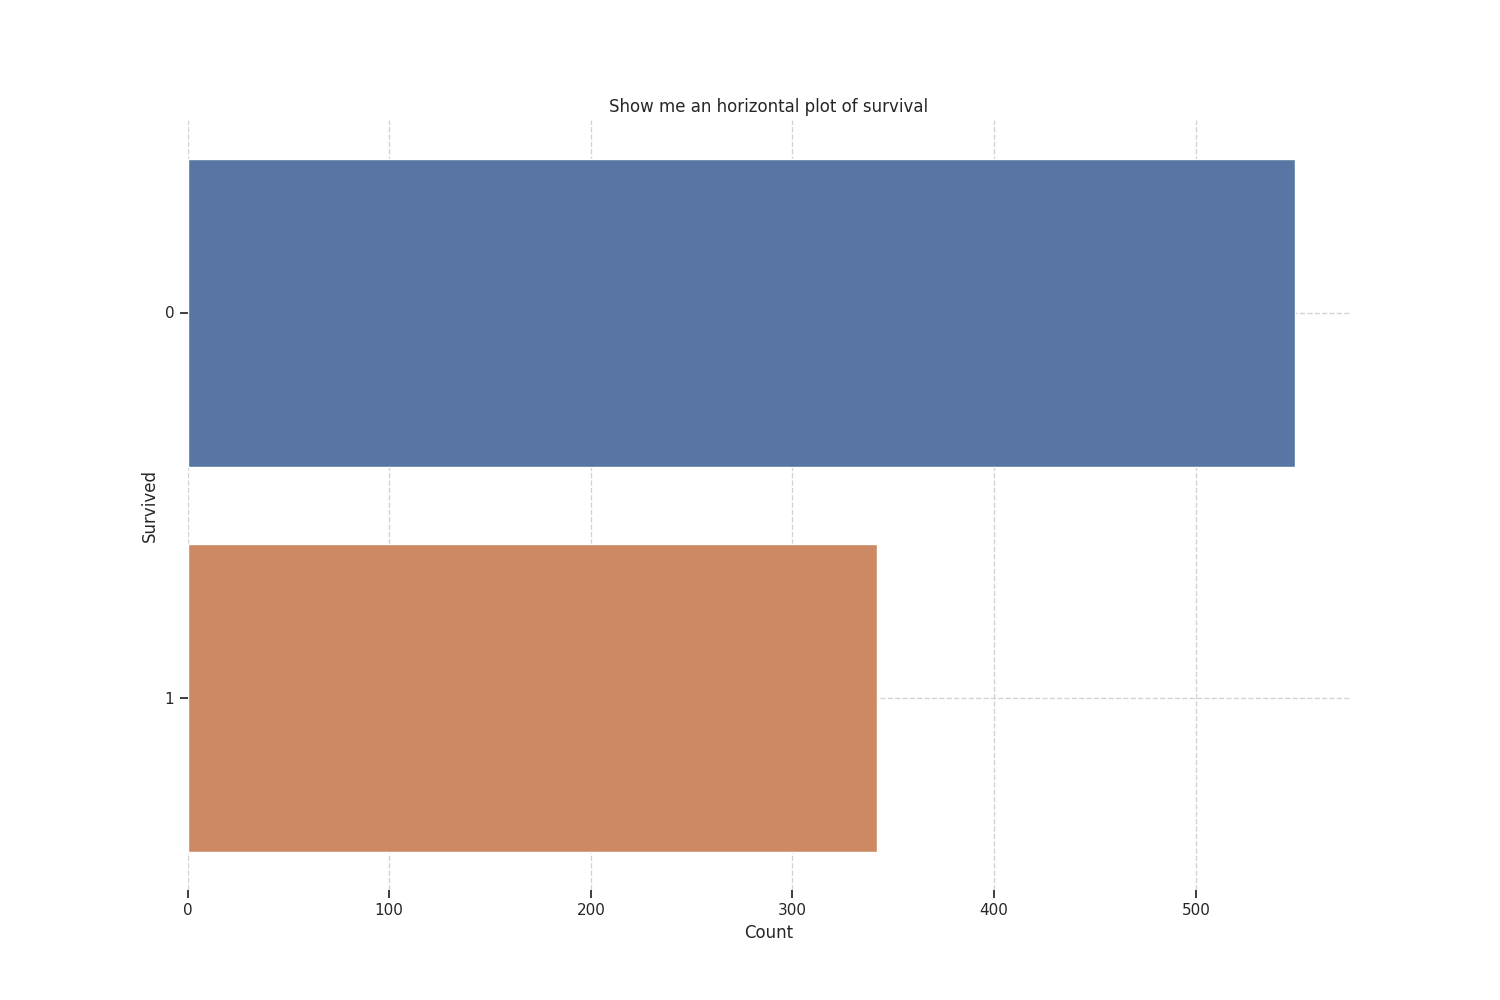

In [40]:
user_query = "Show me an horizontal plot of survival"

textgen_config = TextGenerationConfig(n=1, temperature=0.2, use_cache=True)
charts = lida.visualize(summary=summary, goal=user_query, textgen_config=textgen_config)
charts[0]

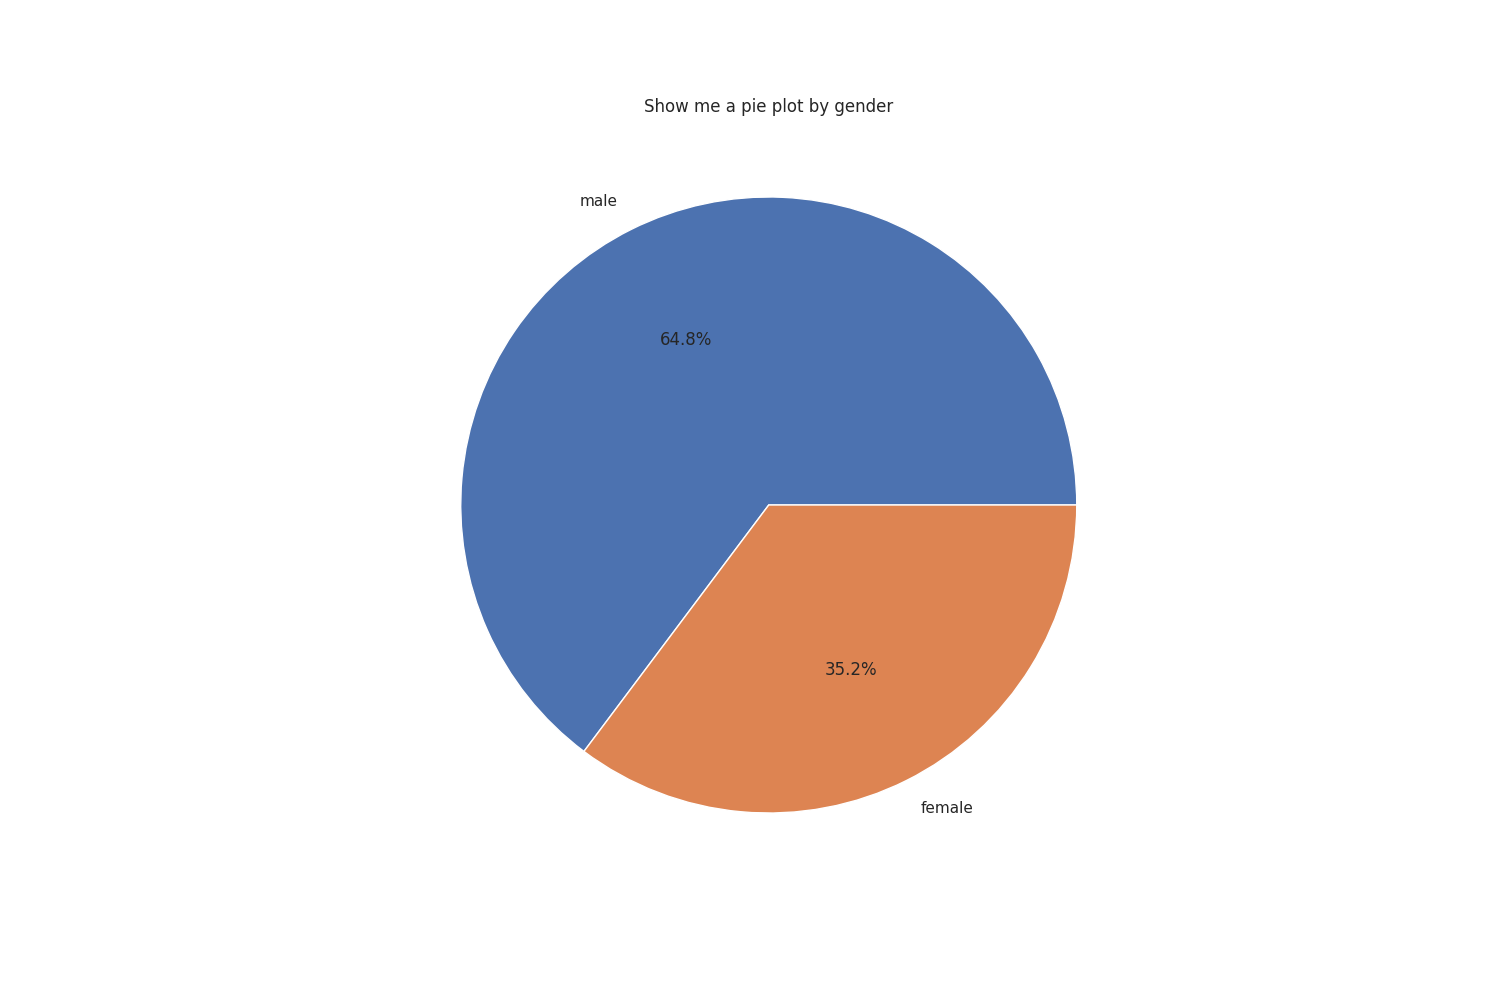

In [41]:
user_query = "Show me a pie plot by gender"

textgen_config = TextGenerationConfig(n=1, temperature=0.2, use_cache=True)
charts = lida.visualize(summary=summary, goal=user_query, textgen_config=textgen_config)
charts[0]

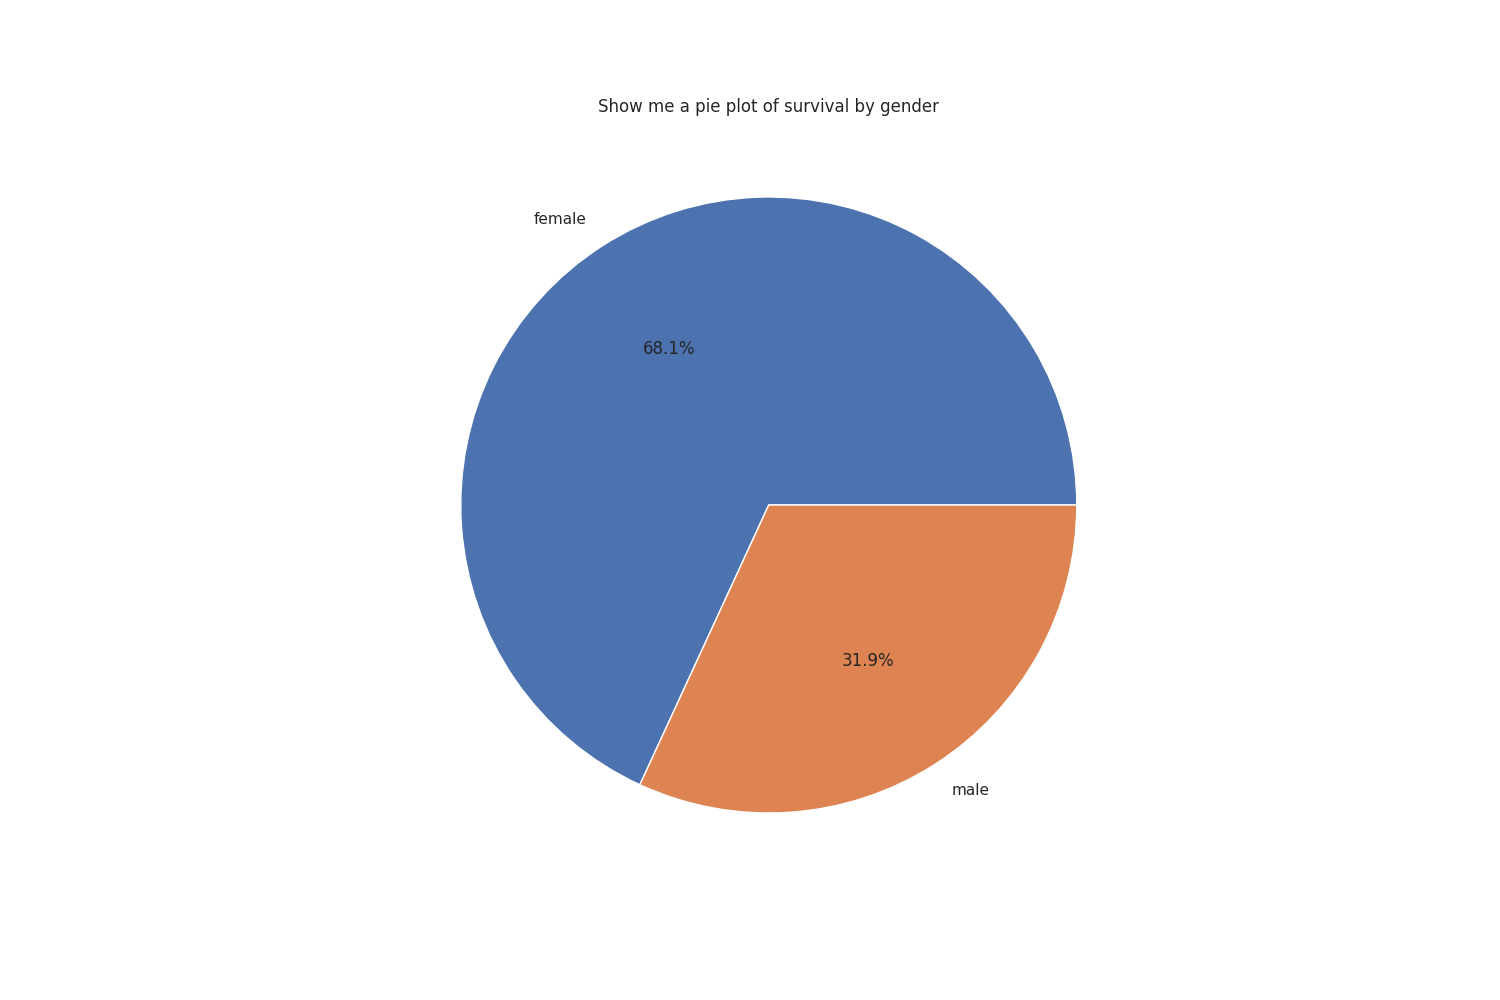

In [42]:
user_query = "Show me a pie plot of survival by gender"

textgen_config = TextGenerationConfig(n=1, temperature=0.2, use_cache=True)
charts = lida.visualize(summary=summary, goal=user_query, textgen_config=textgen_config)
charts[0]

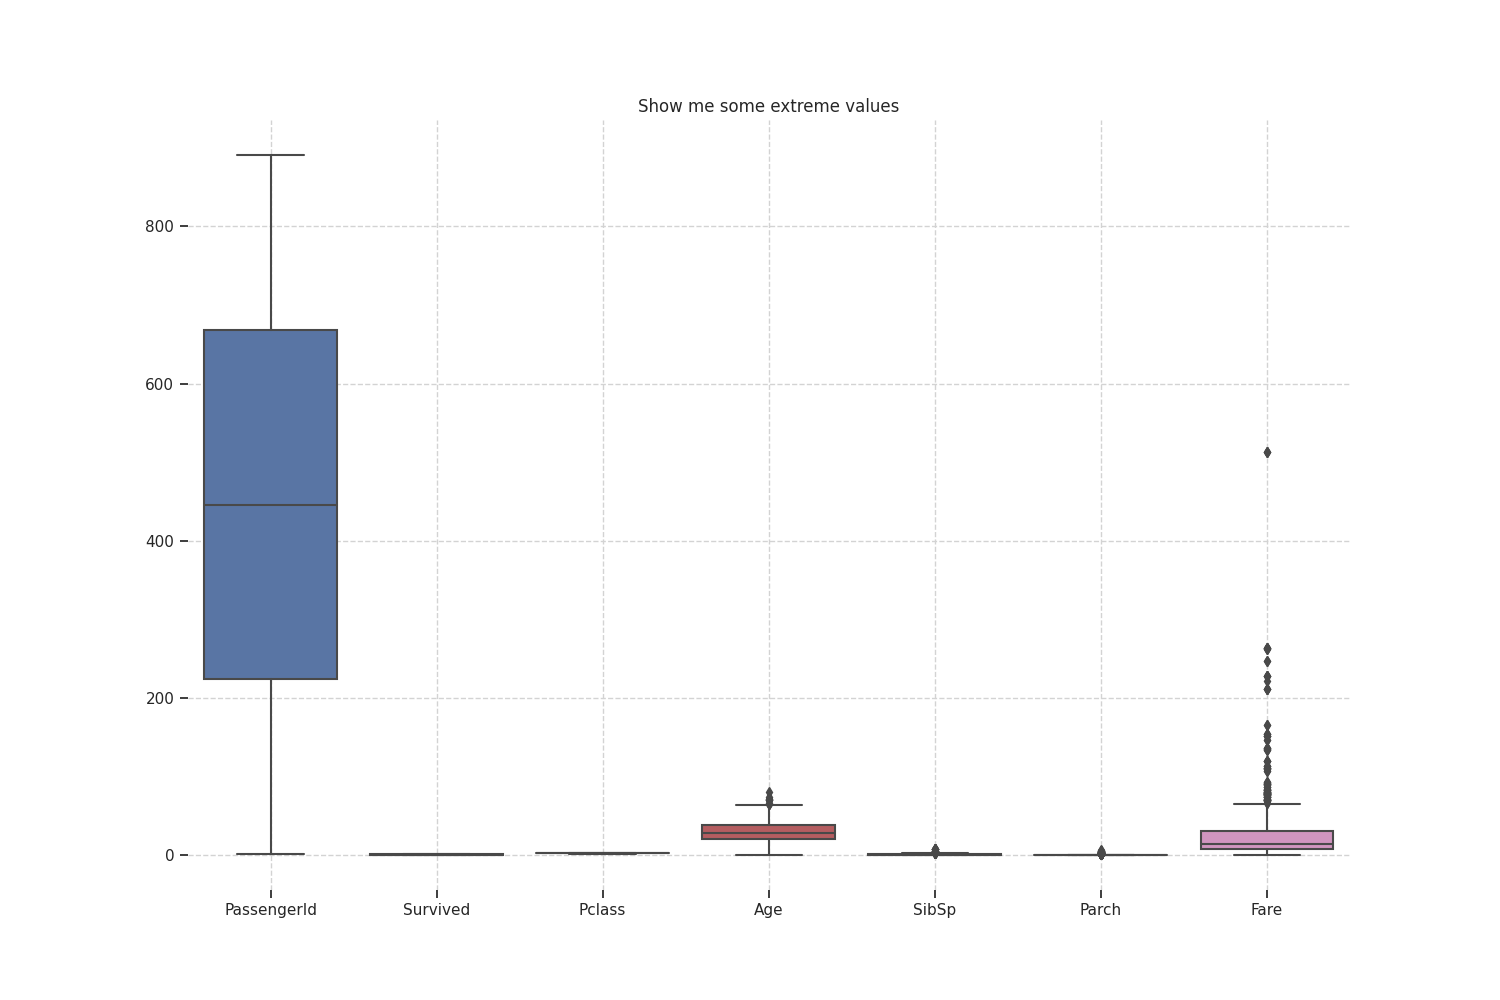

In [43]:
user_query = "Show me some extreme values"

textgen_config = TextGenerationConfig(n=1, temperature=0.2, use_cache=True)
charts = lida.visualize(summary=summary, goal=user_query, textgen_config=textgen_config)
charts[0]

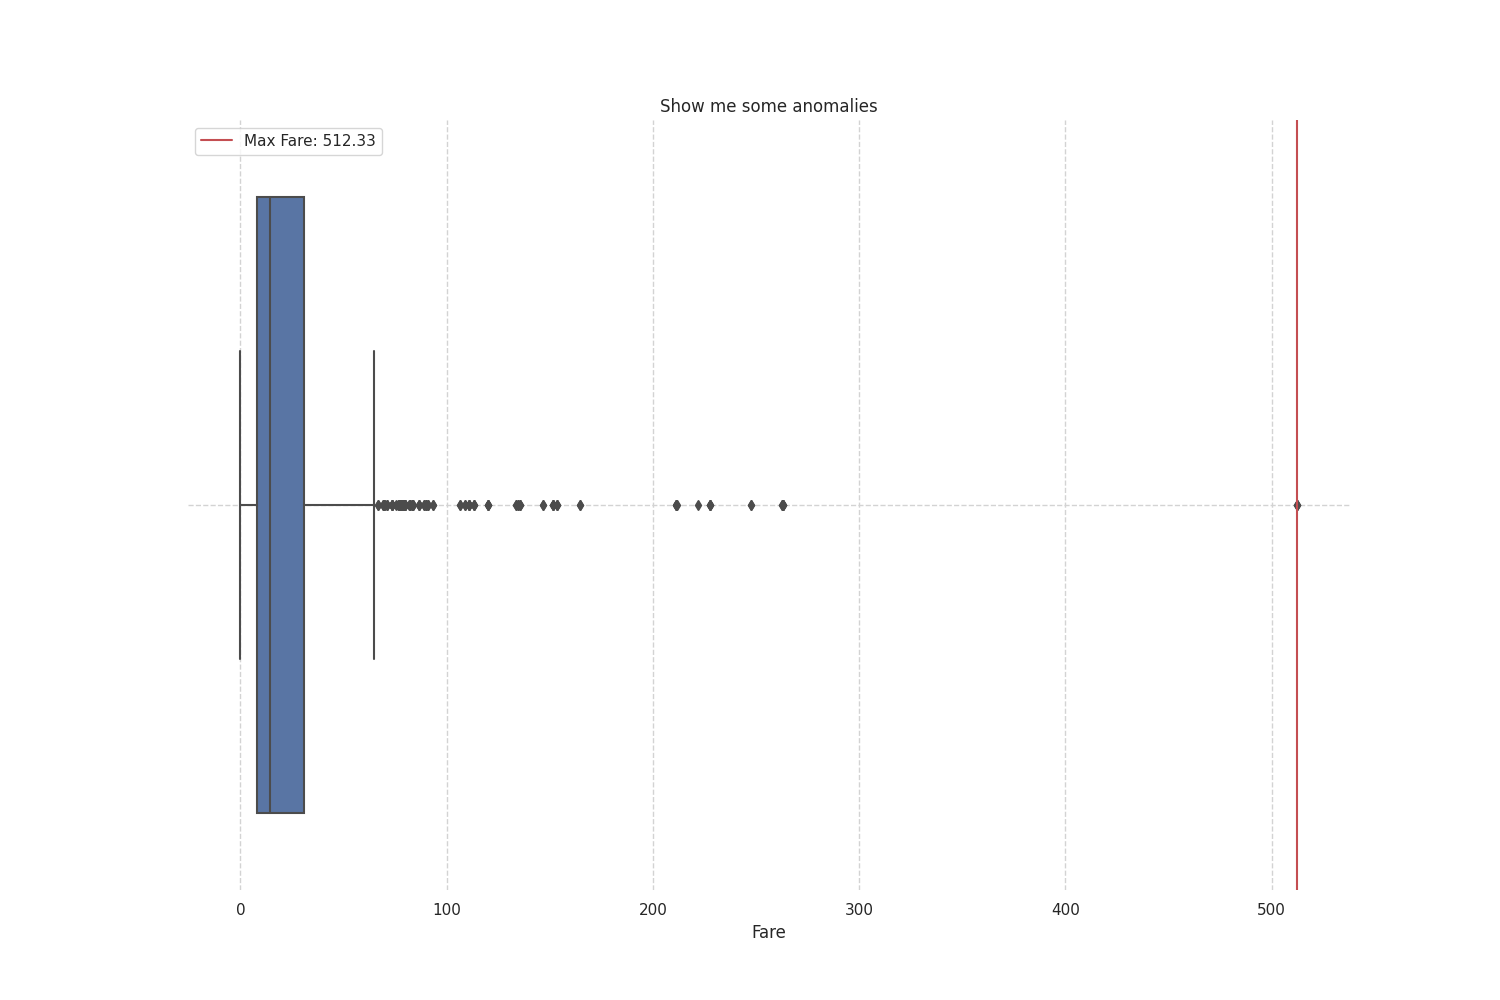

In [44]:
user_query = "Show me some anomalies"

textgen_config = TextGenerationConfig(n=1, temperature=0.2, use_cache=True)
charts = lida.visualize(summary=summary, goal=user_query, textgen_config=textgen_config)
charts[0]

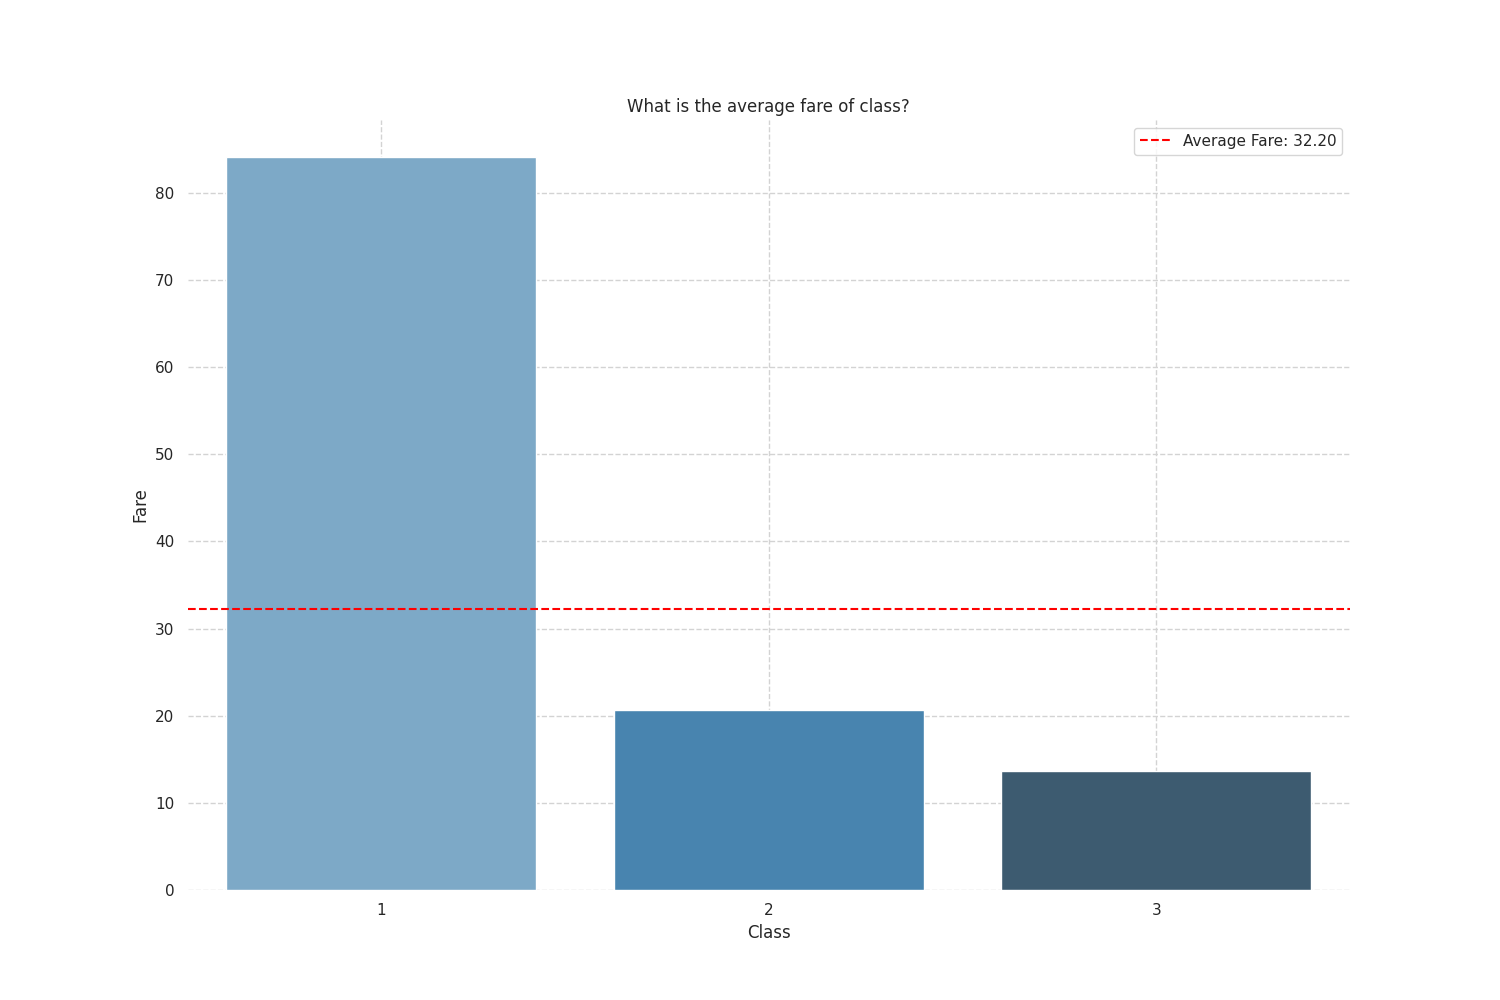

In [45]:
user_query = "What is the average fare of class?"

textgen_config = TextGenerationConfig(n=1, temperature=0.2, use_cache=True)
charts = lida.visualize(summary=summary, goal=user_query, textgen_config=textgen_config)
charts[0]

# 6. VizOps

Given that LIDA represents visualizations as code,
the VISGENERATOR also implements submodules
to perform operations on this representation. 

This includes 
- **Natural language based visualization refinement**: Provides a conversational api to iteratively
4Execution in a sandbox environment is recommended.
refine generated code (e.g., translate chart t hindi
. . . zoom in by 50% etc) which can then be executed to generate new visualizations.
- **Visualization explanations and accessibility**:
Generates natural language explanations (valuable
for debugging and sensemaking) as well as accessibility descriptions (valuable for supporting users
with visual impairments).

- **Visualization code self-evaluation and repair**:
Applies an LLM to self-evaluate generated code on
multiple dimensions (see section 4.1.2).

- **Visualization recommendation**: Given some context (goals, or an existing visualization), recommend additional visualizations to the user (e.g., for
comparison, or to provide additional perspectives).



## Natural language based visualization refinement 

Given some code, modify it based on natural language instructions. This yields a new code snippet that can be executed to generate a new visualization.

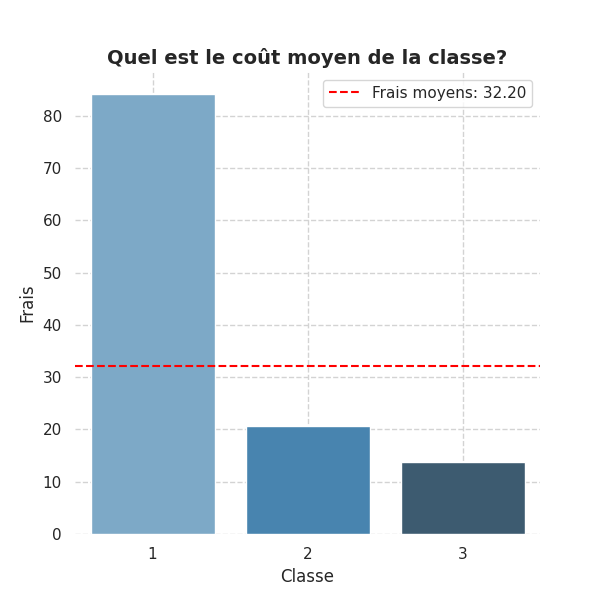

In [46]:
code = charts[0].code
textgen_config = TextGenerationConfig(n=1, temperature=0, use_cache=True)

instructions = [
    "make the chart height and width equal",
    "translate the chart to French",
]

edited_charts = lida.edit(
    code=code,
    summary=summary,
    instructions=instructions,
    library=library,
    textgen_config=textgen_config,
)

edited_charts[0]

## Visualization explanations and accessibility

In [47]:
explanations = lida.explain(code=code, library=library, textgen_config=textgen_config)
explanations

[[{'section': 'accessibility',
   'code': 'None',
   'explanation': 'The goal of the chart is to show the average fare of each passenger class. The chart is a barplot with the x-axis representing the passenger class and the y-axis representing the average fare. The bars are colored in shades of blue, and a red dashed line is added to represent the overall average fare. The chart is easy to read and understand, with clear labels and a legend.'},
  {'section': 'transformation',
   'code': "fare_by_class = data.groupby('Pclass')['Fare'].mean().reset_index()",
   'explanation': 'This section groups the data by passenger class and calculates the mean fare for each class. The resulting dataframe has two columns: Pclass and Fare. The reset_index() method is used to convert the groupby object to a dataframe.'},
  {'section': 'visualization',
   'code': "# create a barplot of the fare by class\nax = sns.barplot(x='Pclass', y='Fare', data=fare_by_class, palette='Blues_d')\n# add a horizontal lin

### Python code

In [48]:
for row in explanations[0]:
    print(row["code"], " ** ", row["code"])

None  **  None
fare_by_class = data.groupby('Pclass')['Fare'].mean().reset_index()  **  fare_by_class = data.groupby('Pclass')['Fare'].mean().reset_index()
# create a barplot of the fare by class
ax = sns.barplot(x='Pclass', y='Fare', data=fare_by_class, palette='Blues_d')
# add a horizontal line with the average fare value
avg_fare = data['Fare'].mean()
ax.axhline(avg_fare, color='red', linestyle='--', label=f'Average Fare: {avg_fare:.2f}')
# set the axis labels and legend
ax.set_xlabel('Class')
ax.set_ylabel('Fare')
ax.legend()
plt.title('What is the average fare of class?', wrap=True)  **  # create a barplot of the fare by class
ax = sns.barplot(x='Pclass', y='Fare', data=fare_by_class, palette='Blues_d')
# add a horizontal line with the average fare value
avg_fare = data['Fare'].mean()
ax.axhline(avg_fare, color='red', linestyle='--', label=f'Average Fare: {avg_fare:.2f}')
# set the axis labels and legend
ax.set_xlabel('Class')
ax.set_ylabel('Fare')
ax.legend()
plt.title('What is t

### Explanation

In [49]:
for row in explanations[0]:
    print(row["section"], " ** ", row["explanation"])

accessibility  **  The goal of the chart is to show the average fare of each passenger class. The chart is a barplot with the x-axis representing the passenger class and the y-axis representing the average fare. The bars are colored in shades of blue, and a red dashed line is added to represent the overall average fare. The chart is easy to read and understand, with clear labels and a legend.
transformation  **  This section groups the data by passenger class and calculates the mean fare for each class. The resulting dataframe has two columns: Pclass and Fare. The reset_index() method is used to convert the groupby object to a dataframe.
visualization  **  This section creates the barplot using the seaborn library. The x-axis is set to 'Pclass', the y-axis is set to 'Fare', and the data is set to the fare_by_class dataframe. The palette is set to 'Blues_d' to color the bars. A horizontal line is added to the plot using the axhline() method, with the y-value set to the overall average f

## Visualization code self-evaluation and repair

In [50]:
evaluations = lida.evaluate(
    code=code, goal=goals[i], textgen_config=textgen_config, library=library
)[0]

evaluations

[{'dimension': 'bugs',
  'score': 10,
  'rationale': 'The code is free of bugs, syntax errors, and typos. It is also well-structured and easy to read.'},
 {'dimension': 'transformation',
  'score': 10,
  'rationale': 'The data is appropriately transformed by grouping the data by Pclass and calculating the mean fare. This is appropriate for the visualization type.'},
 {'dimension': 'compliance',
  'score': 9,
  'rationale': 'The code meets the specified visualization goal of showing the distribution of passengers by embarkation point. However, the title of the chart does not match the goal.'},
 {'dimension': 'type',
  'score': 8,
  'rationale': 'While the barplot is appropriate for showing the distribution of passengers by embarkation point, a histogram or density plot may be more effective in showing the distribution of passengers.'},
 {'dimension': 'encoding',
  'score': 9,
  'rationale': 'The data is appropriately encoded by using the x-axis to represent the Pclass and the y-axis to 

In [51]:
for eval in evaluations:
    print(eval["dimension"], "Score", eval["score"], "/ 10")
    print("  ", eval["rationale"][:200])
    print()

bugs Score 10 / 10
   The code is free of bugs, syntax errors, and typos. It is also well-structured and easy to read.

transformation Score 10 / 10
   The data is appropriately transformed by grouping the data by Pclass and calculating the mean fare. This is appropriate for the visualization type.

compliance Score 9 / 10
   The code meets the specified visualization goal of showing the distribution of passengers by embarkation point. However, the title of the chart does not match the goal.

type Score 8 / 10
   While the barplot is appropriate for showing the distribution of passengers by embarkation point, a histogram or density plot may be more effective in showing the distribution of passengers.

encoding Score 9 / 10
   The data is appropriately encoded by using the x-axis to represent the Pclass and the y-axis to represent the mean fare. However, the color palette could be improved to better differentiate the bars.

aesthetics Score 9 / 10
   The aesthetics of the visualization 

## Visualization Recommendation

In [52]:
textgen_config = TextGenerationConfig(n=2, temperature=0.2, use_cache=True)

recommended_charts = lida.recommend(
    code=code, summary=summary, n=2, textgen_config=textgen_config
)

Recommended 2 charts


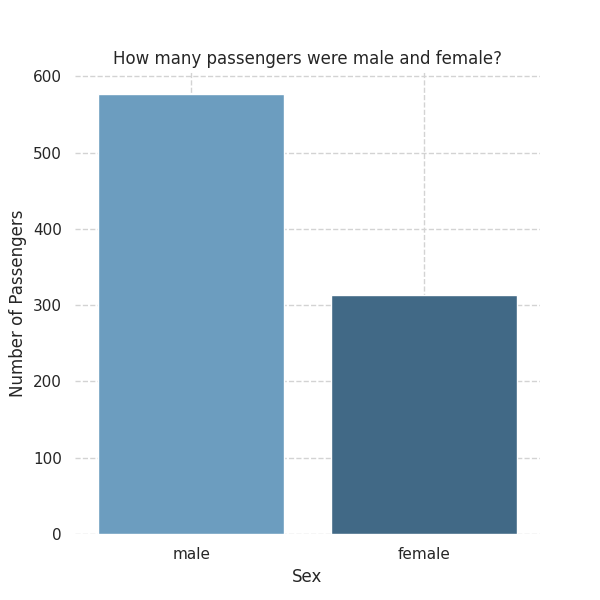

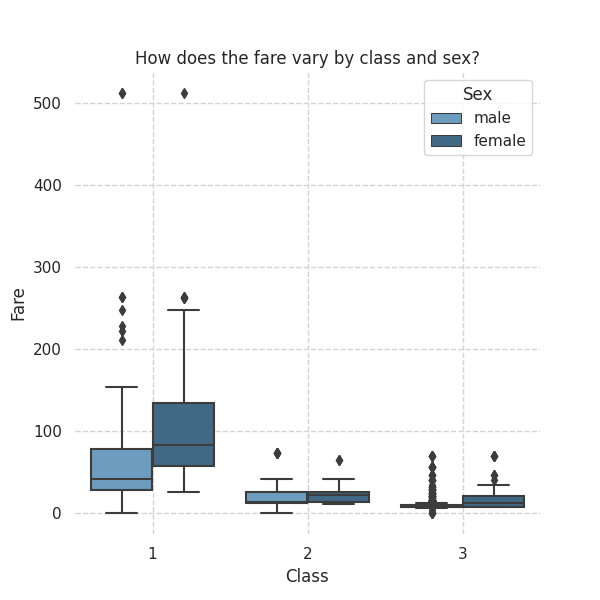

In [53]:
print(f"Recommended {len(recommended_charts)} charts")

for chart in recommended_charts:
    display(chart)

## 7. Infographics (Beta)

- Explores using LIDA to generate infographics from an existing visualization 
- Uses the `peacasso` package, and loads open source stable diffusion models 
- You will need to run `pip install lida[infographics]` to install the required dependencies.
- Currently work in progress (work being done to post process infographics with chart axis and title overlays from the original visualization, add presets for different infographic styles, and add more stable diffusion models)


In [54]:
#!pip install lida[infographics]

In [55]:
# ensure you have a GPU runtime

if torch.cuda.is_available() == "gpu":
    infographics = lida.infographics(
        visualization=edited_charts[0].raster,
        n=1,
        style_prompt="pastel art, green pearly rain drops, highly detailed, no blur, white background",
    )

else:
    print("Not available on CPU. GPU is required")

Not available on CPU. GPU is required


In [56]:
if torch.cuda.is_available() == "gpu":
    plot_raster([edited_charts[0].raster, infographics["images"][0]])

else:
    print("Not available on CPU. GPU is required")

Not available on CPU. GPU is required
